In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from models import U_Net_big
from RectifiedFlow import RectifiedFlow_Unet, train, train_reflow

from util import load_MNIST, show_samples, show_trajectories, show_samples_array, show_sample_temperature, show_trajecrory_samples, show_sample_steps, show_sample_flows

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 512
train_dataset, test_dataset, train_dataloader, test_dataloader, classes = load_MNIST(batch_size, classes=[6])
input_shape = (batch_size, 2, 32, 32)

def get_samples(shape, device):
    return torch.randn(shape, device=device)

In [4]:
v_model_1 = U_Net_big(input_shape=input_shape, output_channels=1, device=device)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [5]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=1e-3)
scheduler_1 = None # optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

0


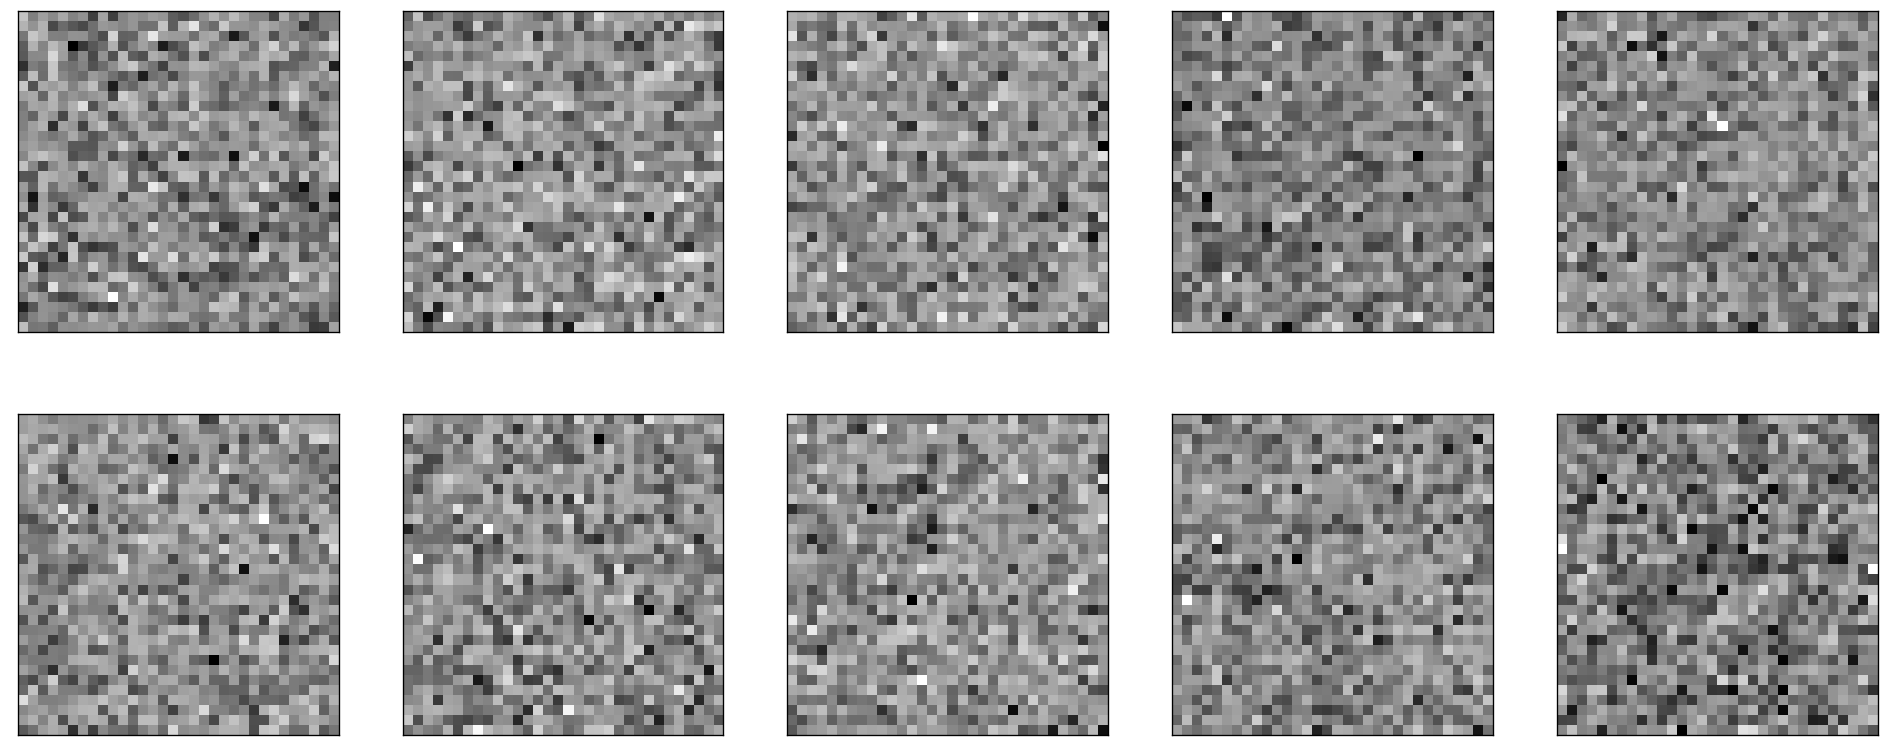

60


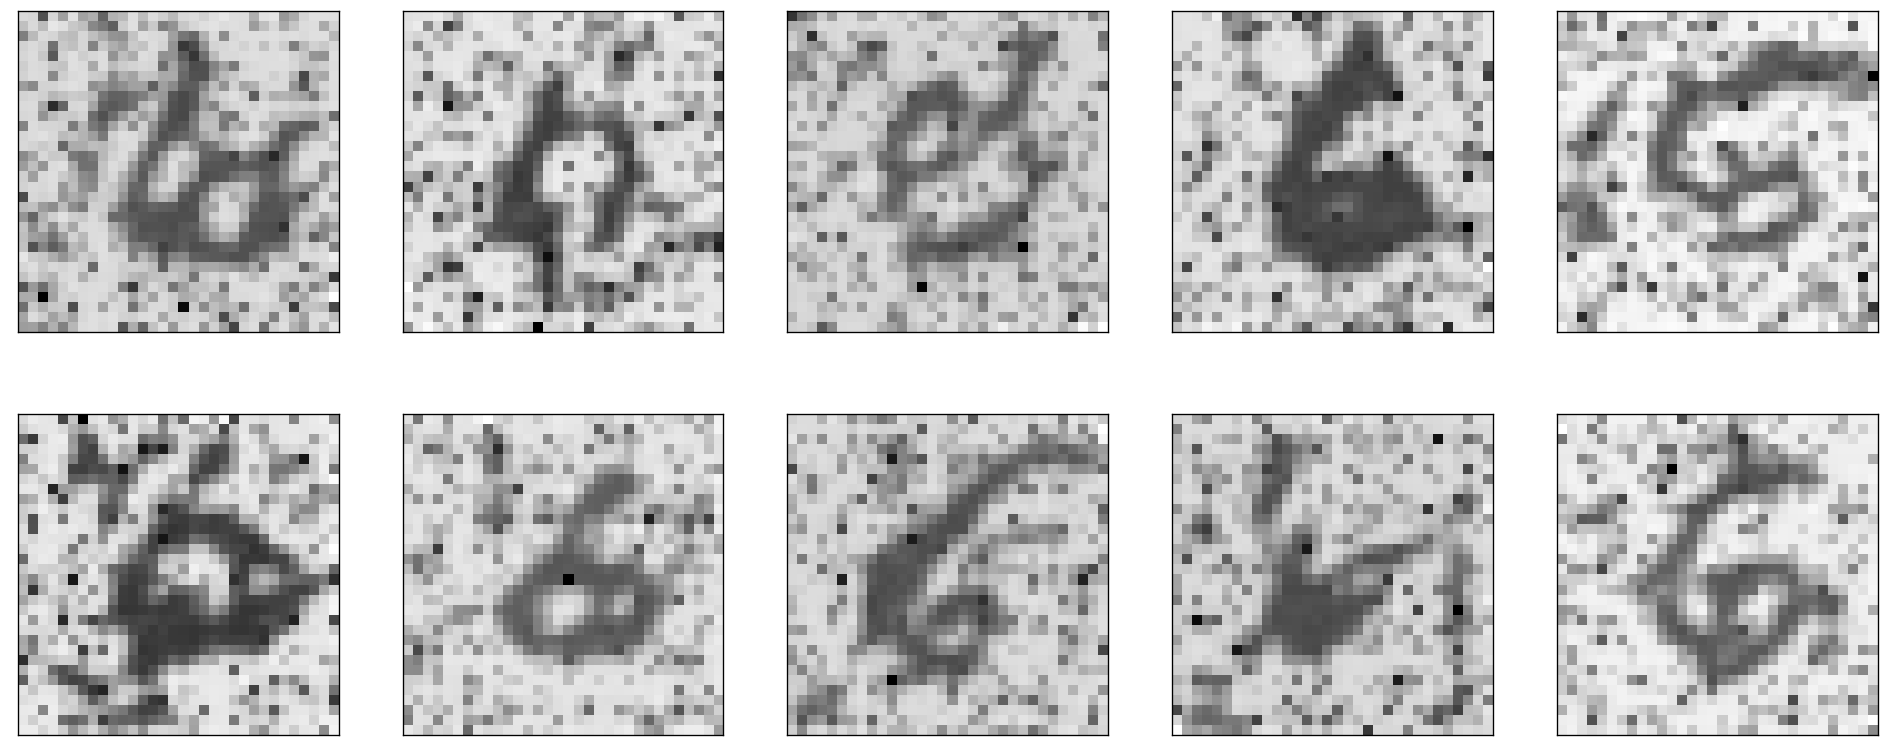

120


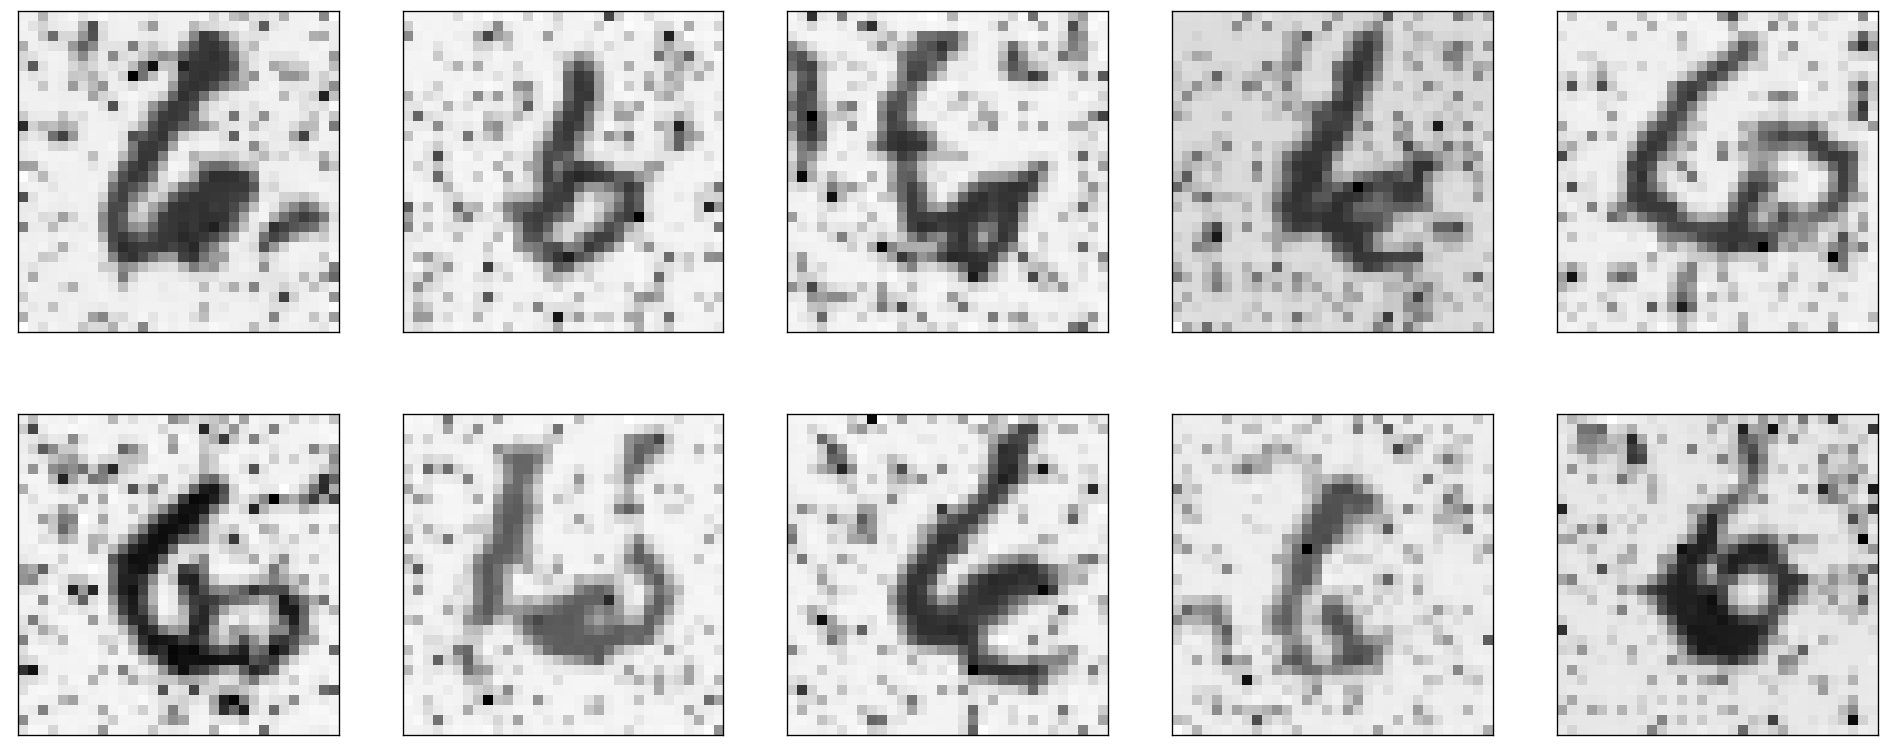

180


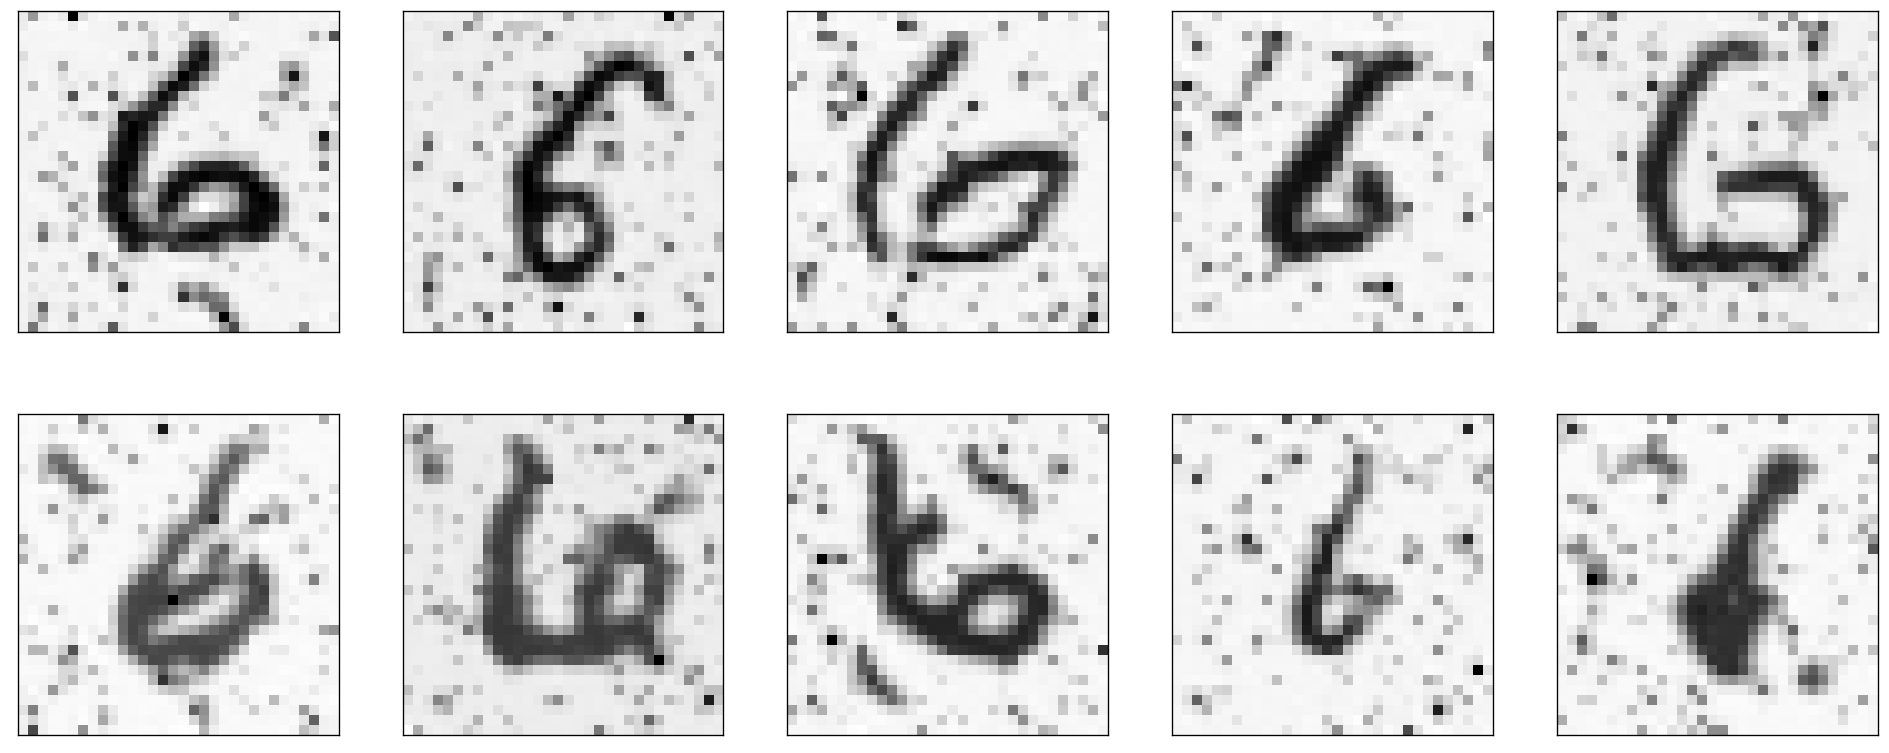

240


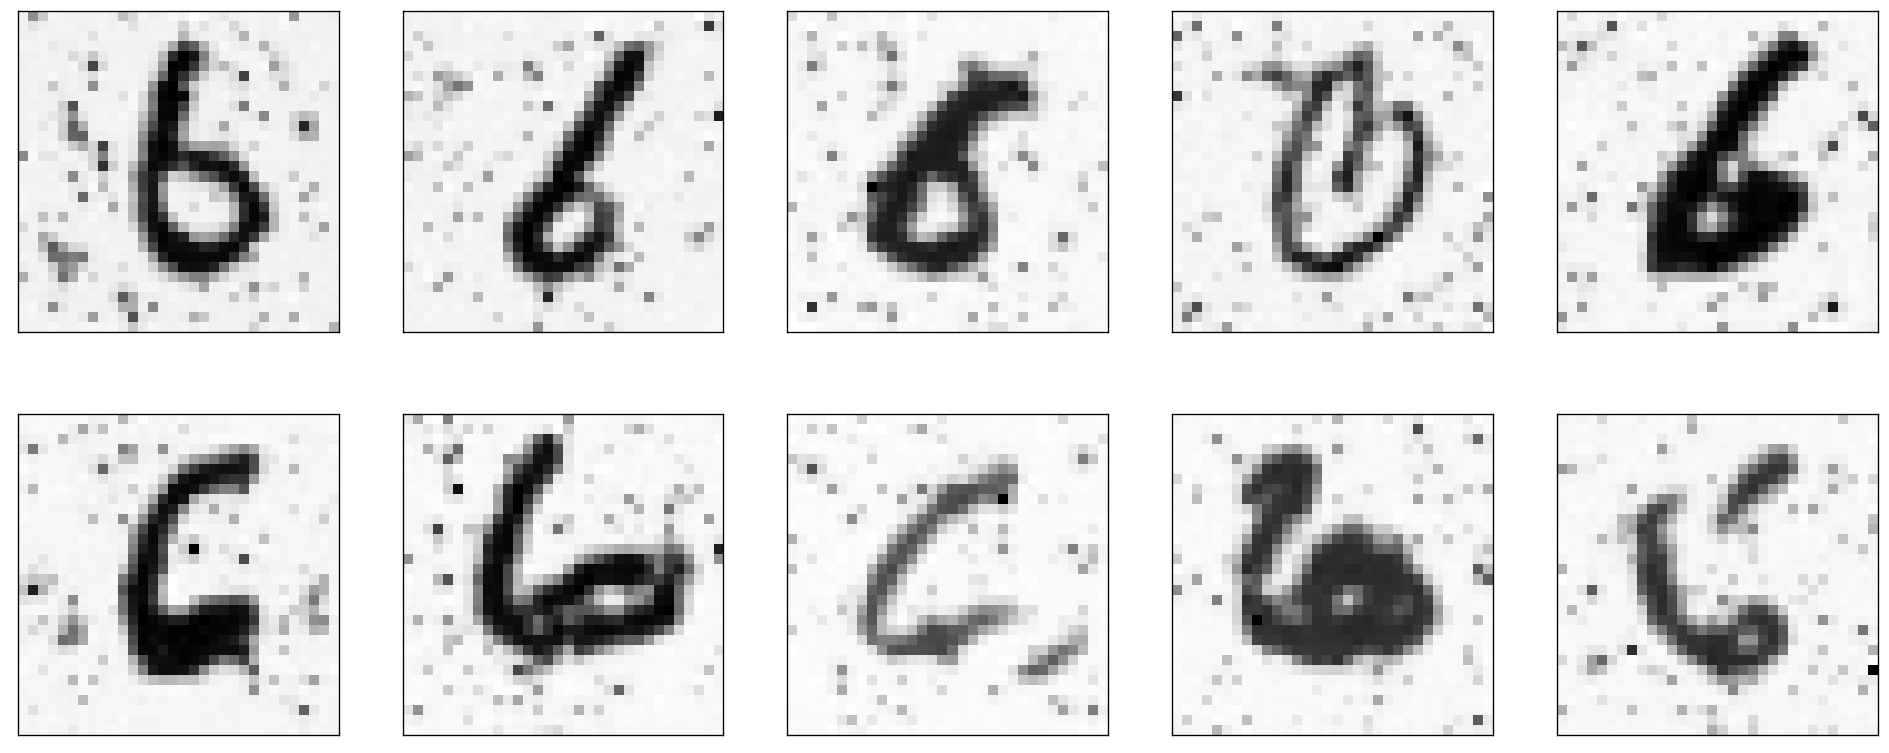

300


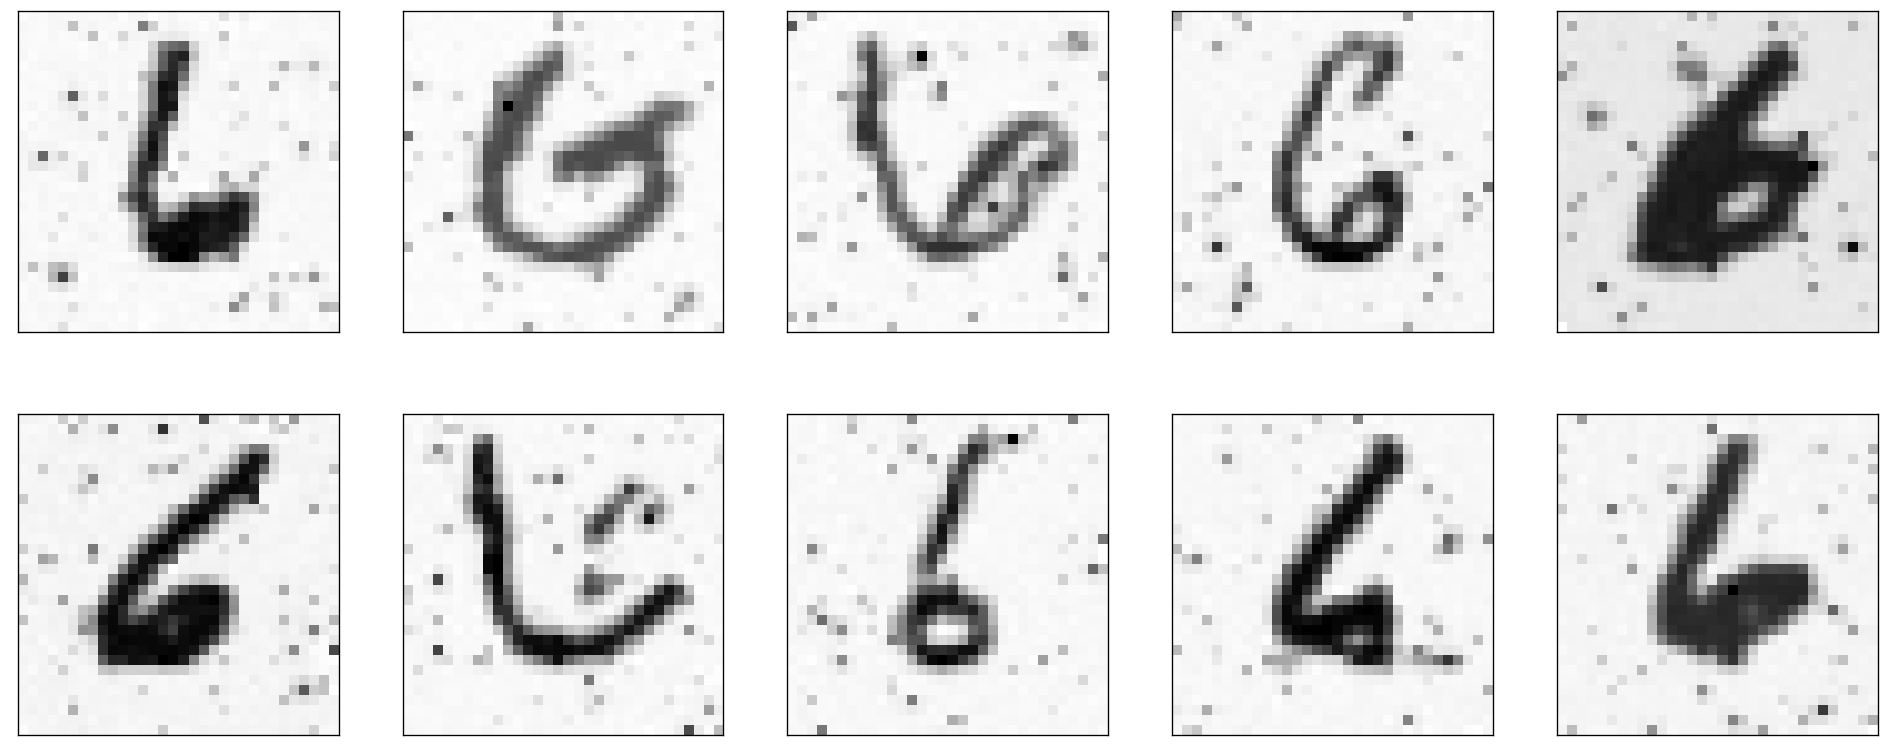

360


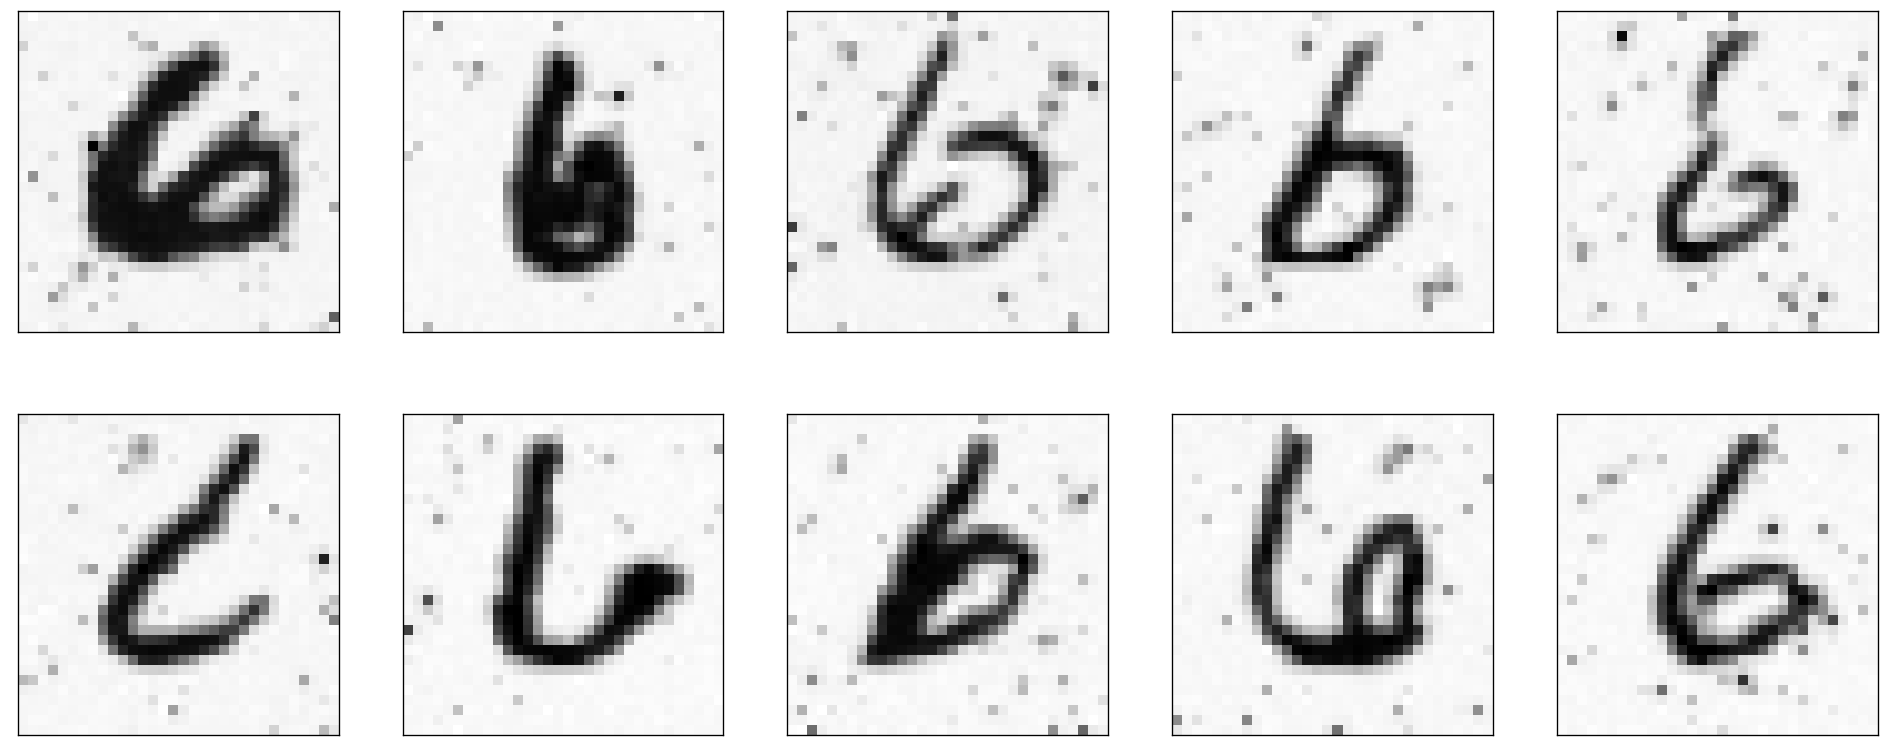

420


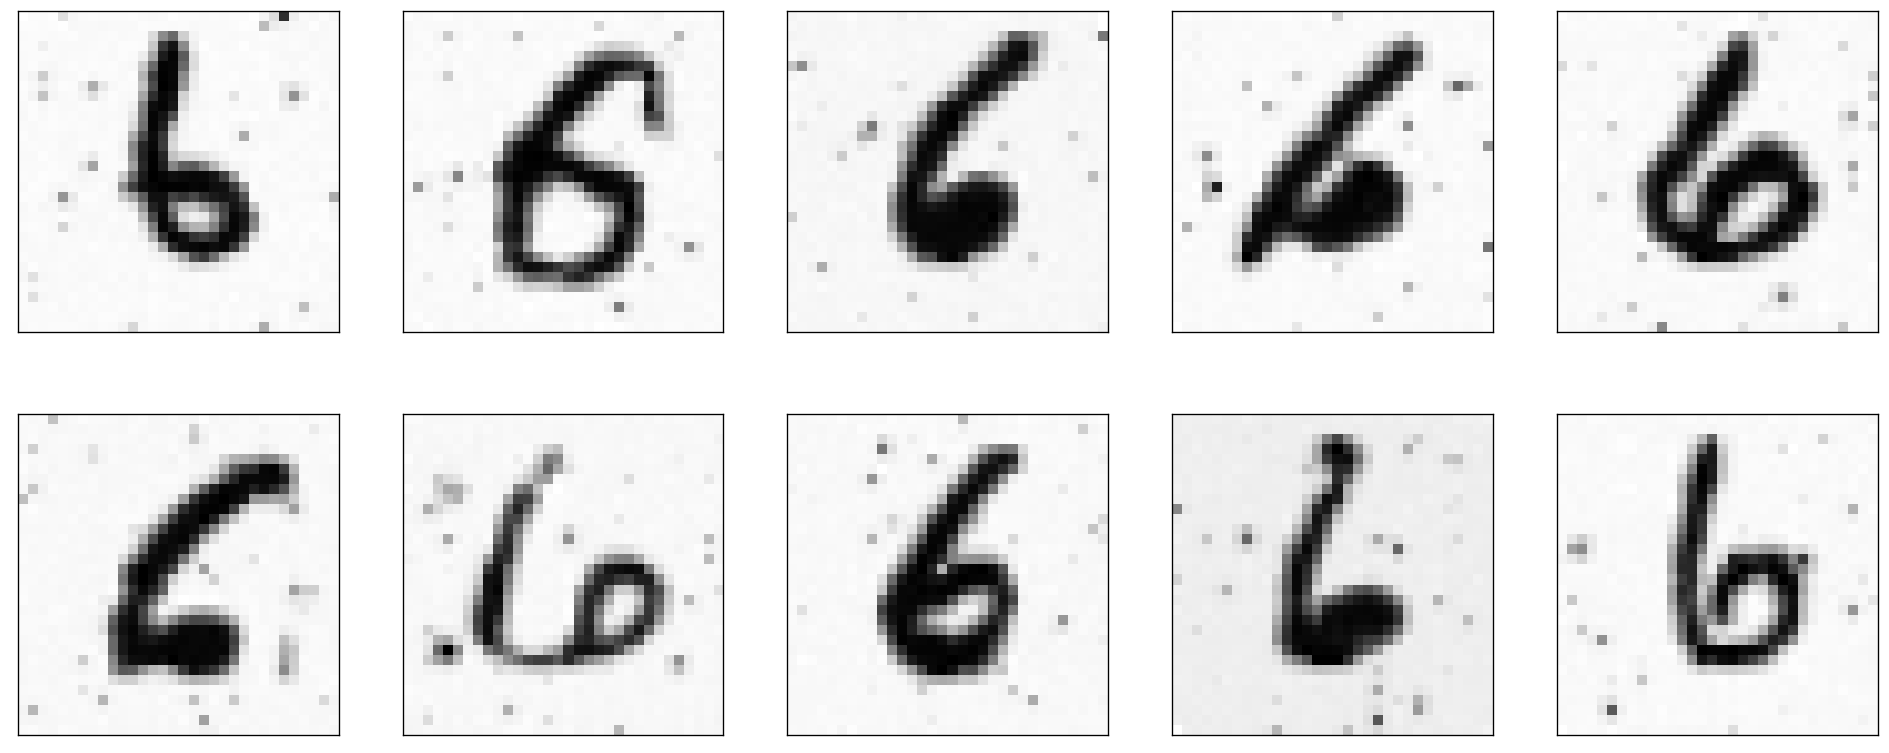

480


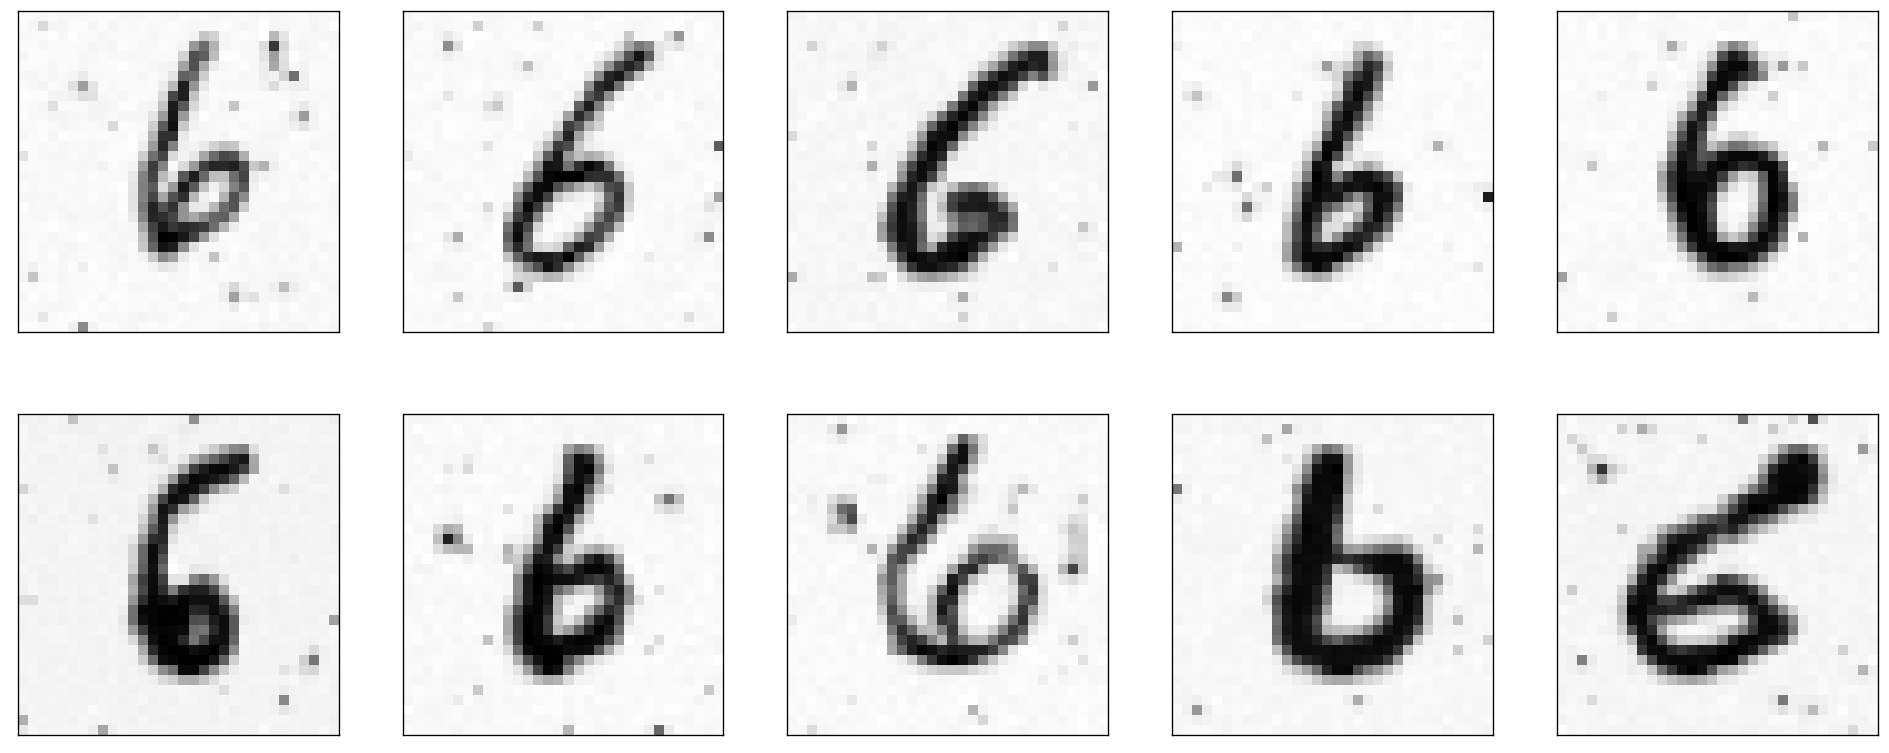

540


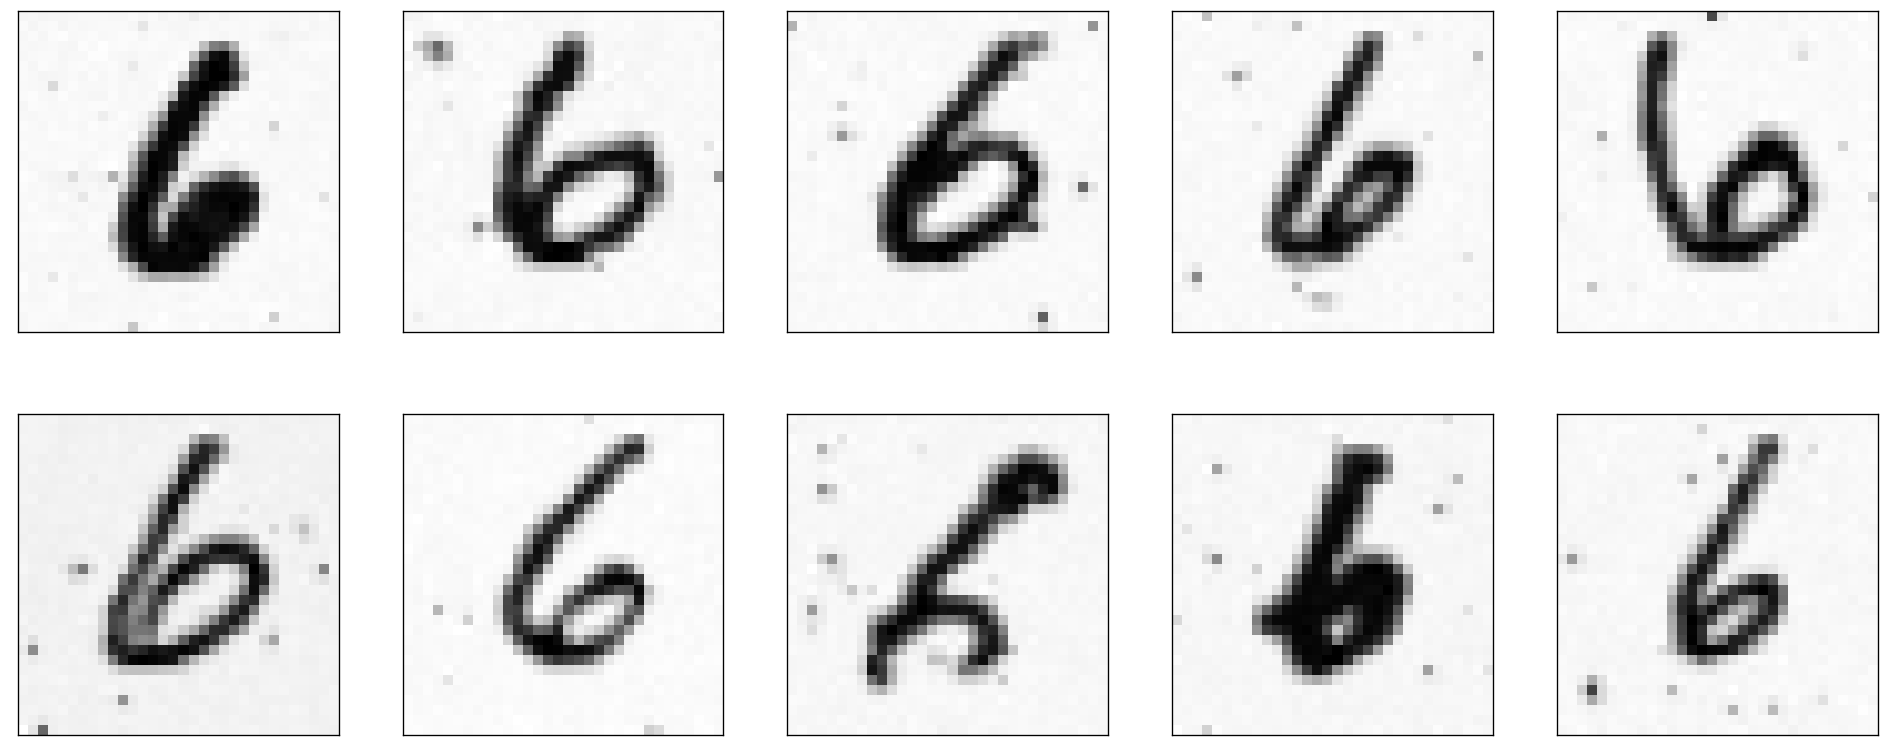

600


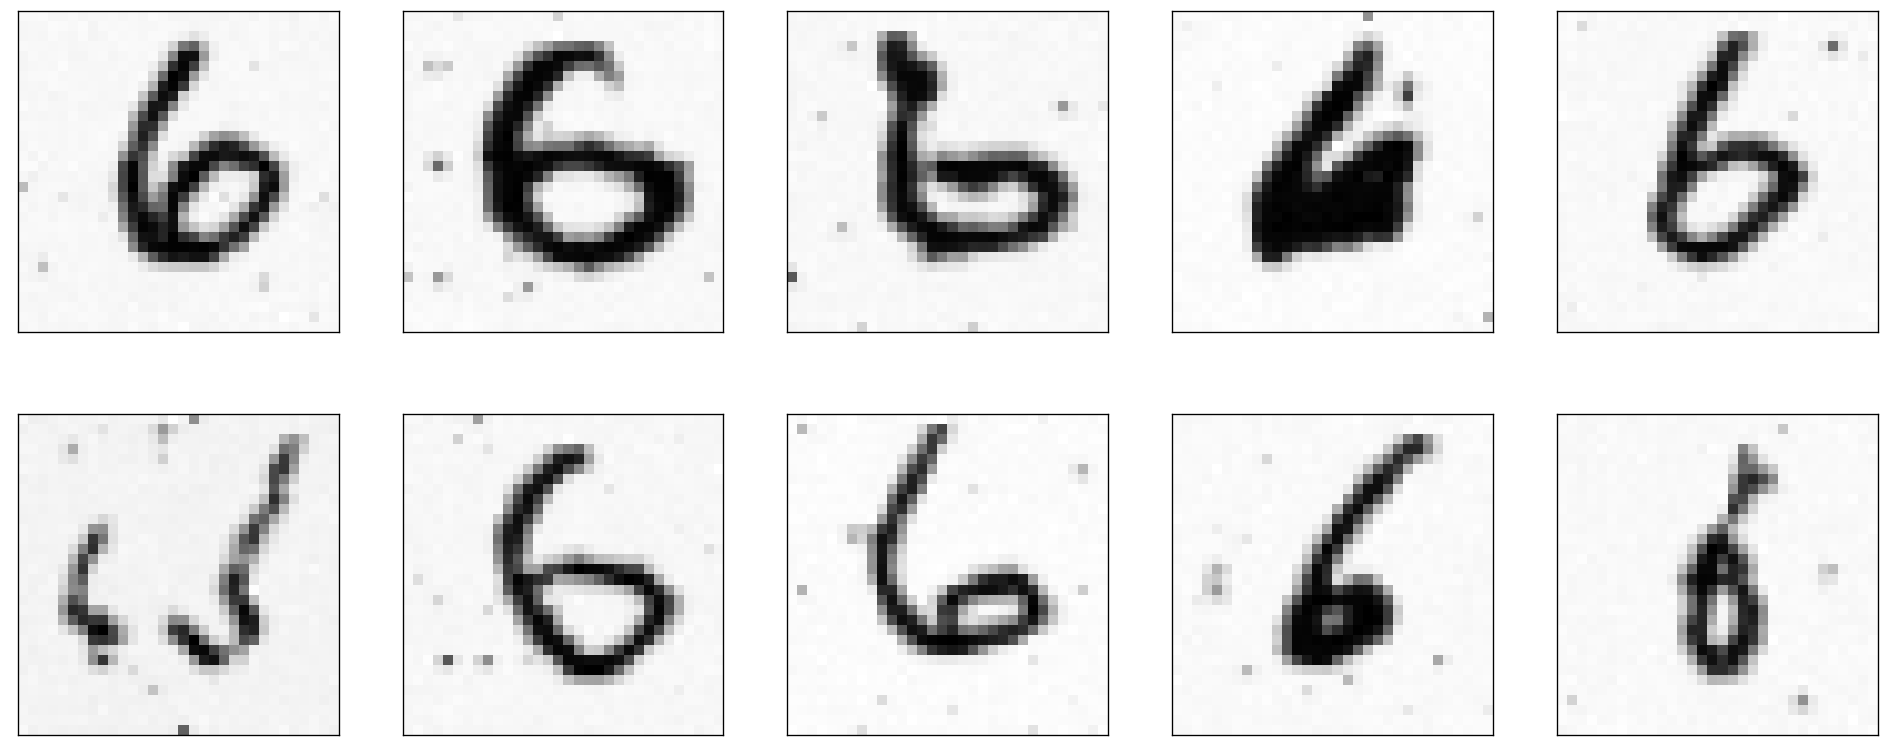

660


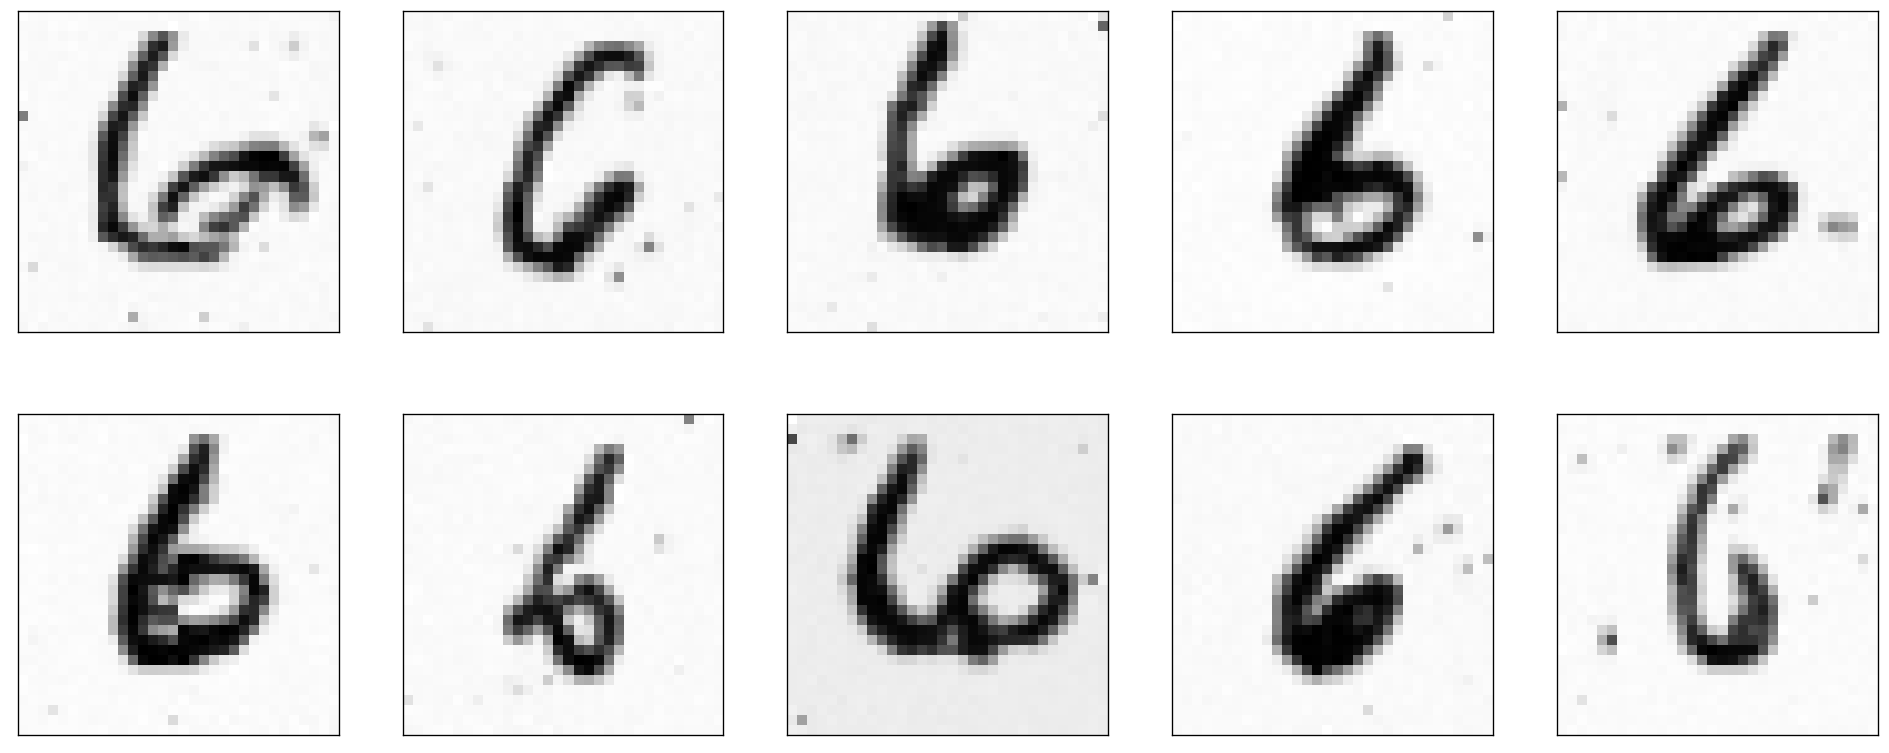

720


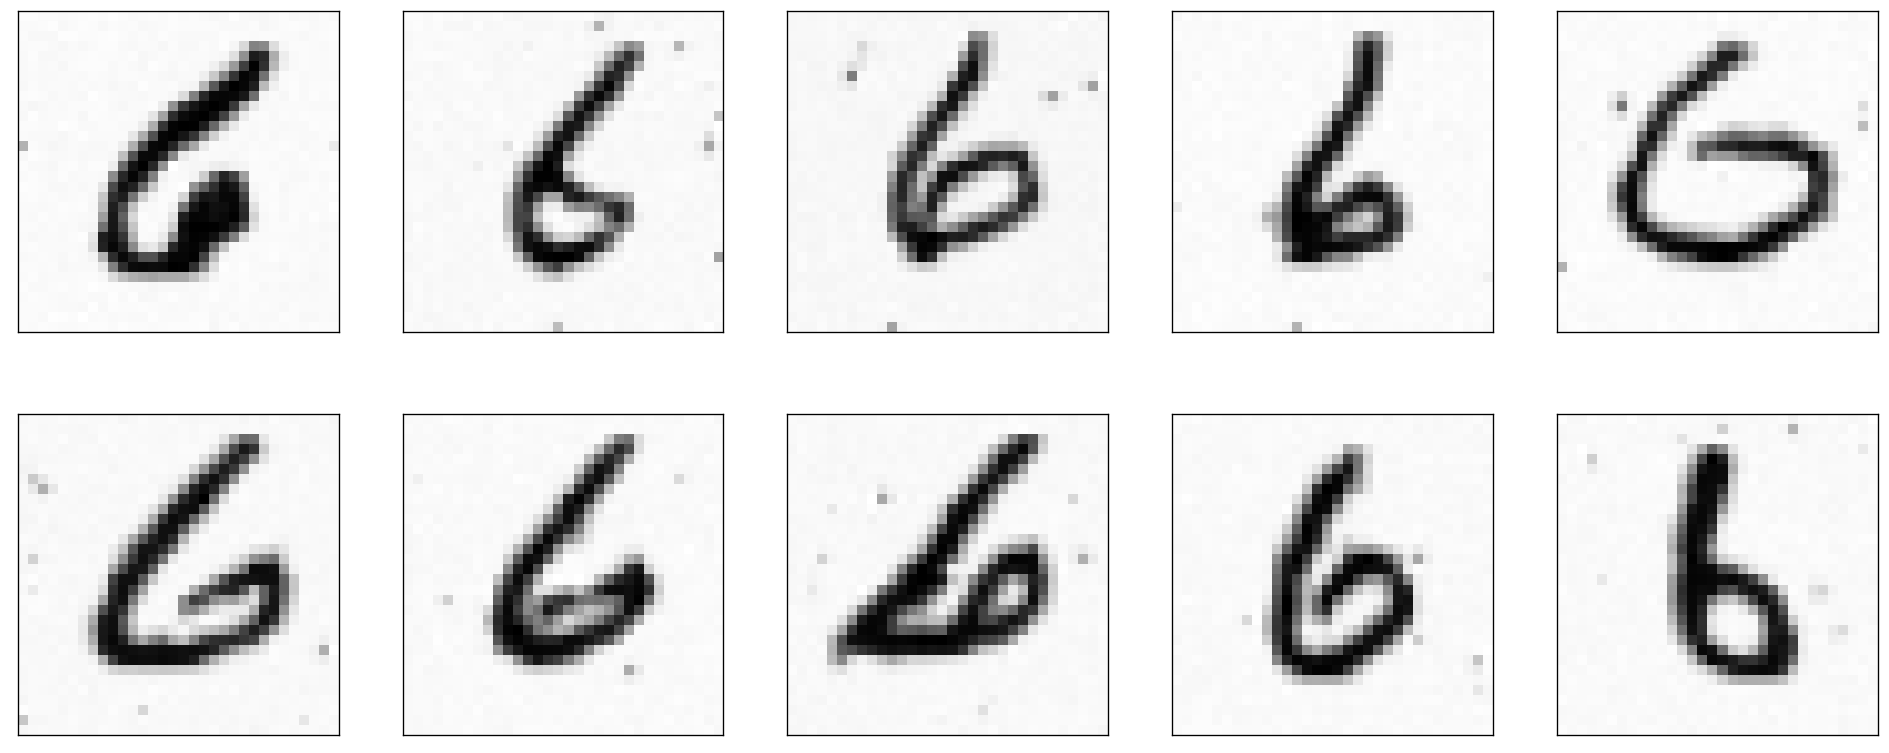

780


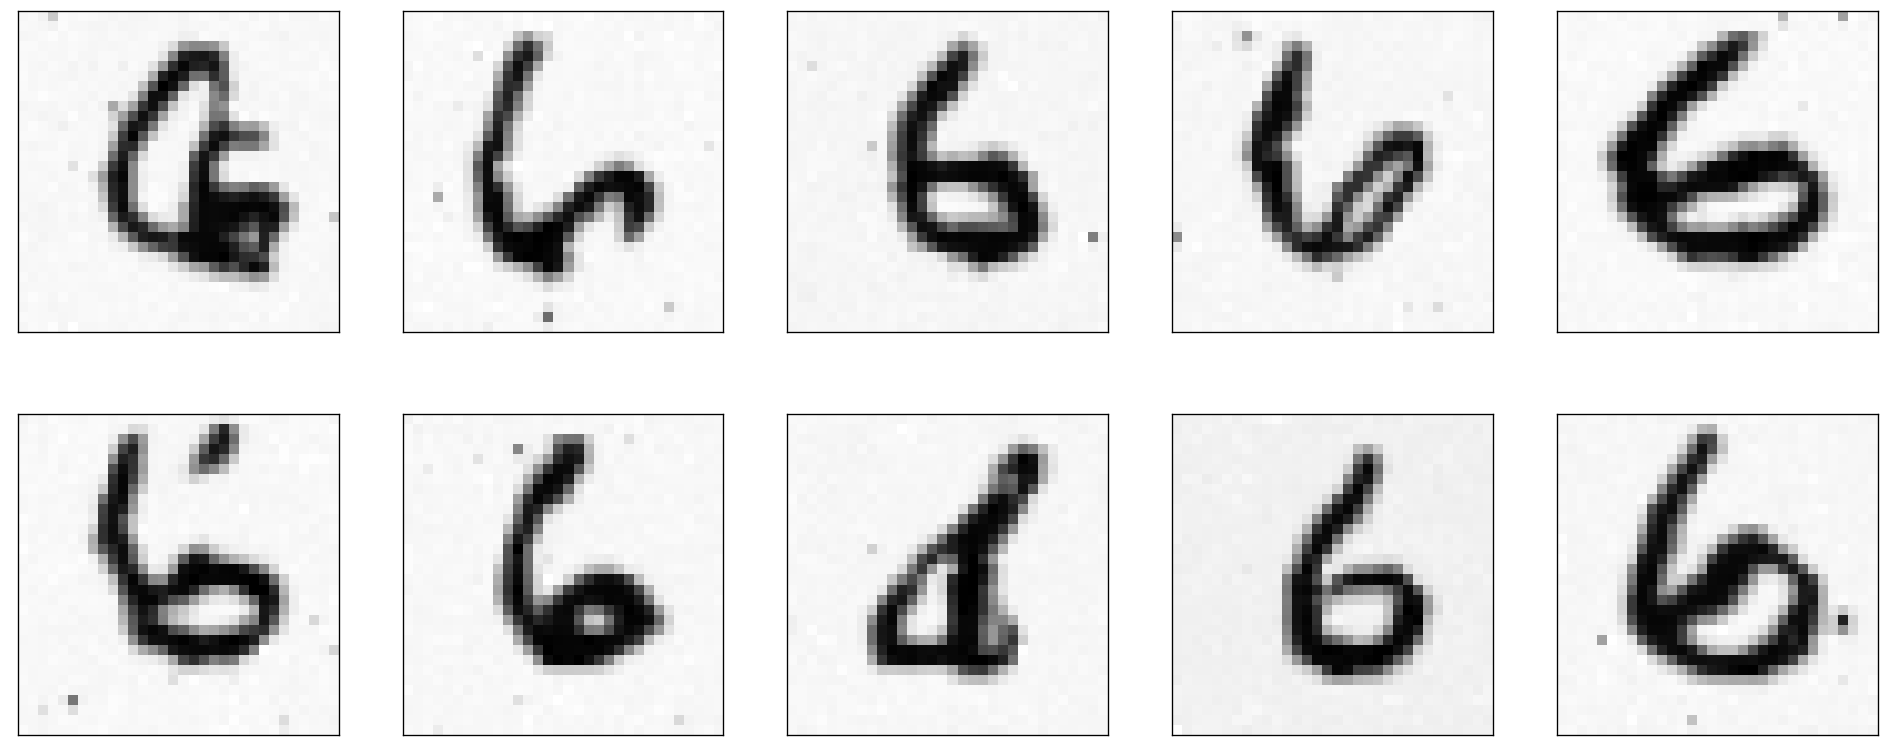

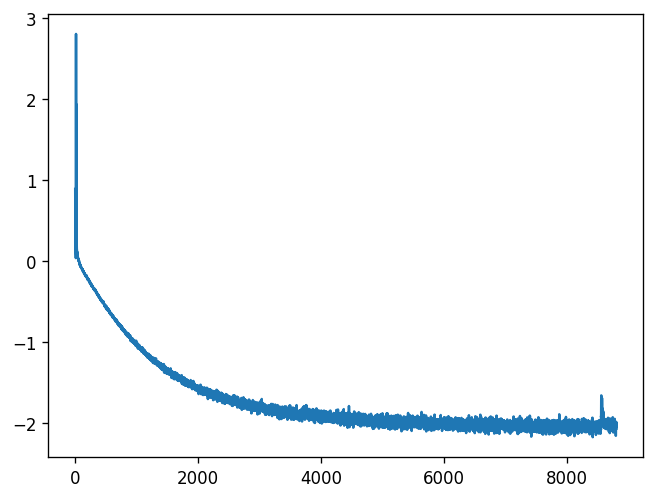

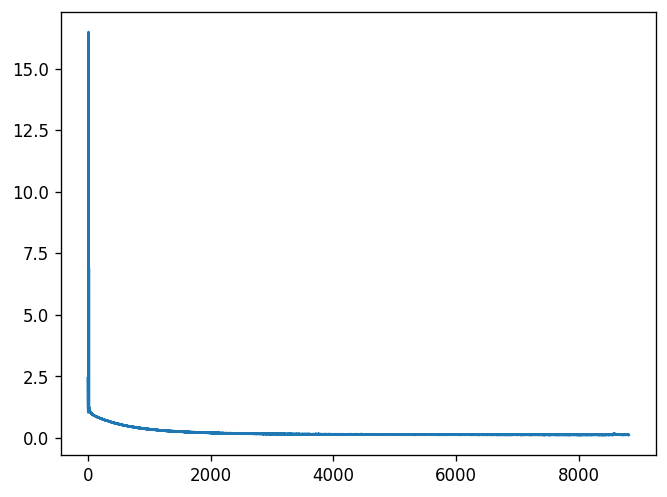

In [6]:
rectified_flow_1 = train(rectified_flow_1, False, optimizer_1, scheduler_1, train_dataloader, get_samples, device, epochs=801, noise_factor=0.01)
plt.plot(np.log(rectified_flow_1.loss_curve))
plt.show()
plt.plot(rectified_flow_1.loss_curve)
plt.show()

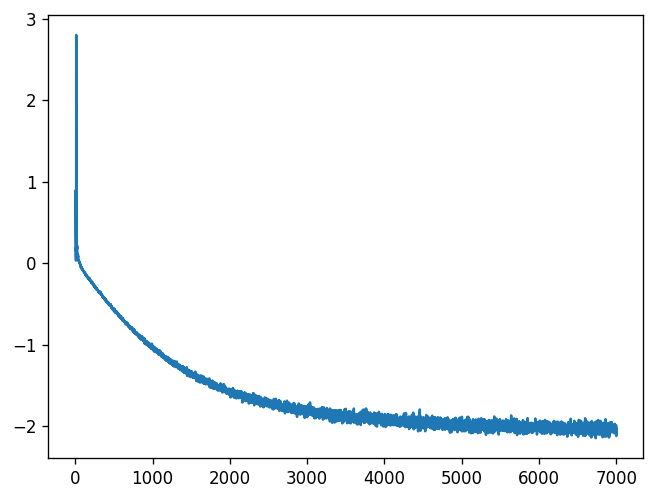

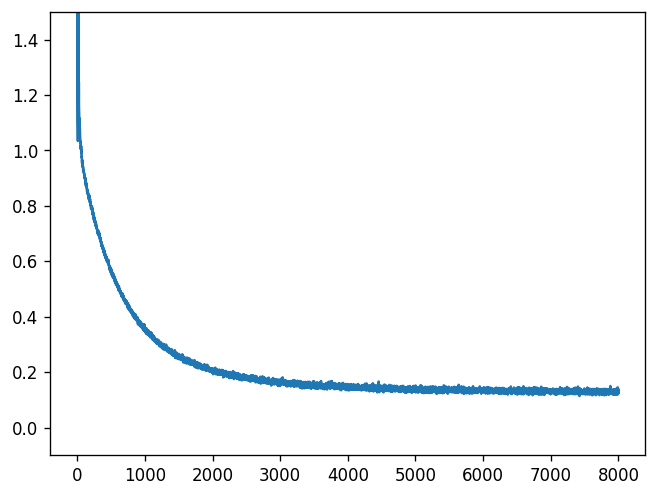

In [13]:
len(rectified_flow_1.loss_curve)
plt.plot(np.log(rectified_flow_1.loss_curve[:7000]))
plt.show()
plt.plot(rectified_flow_1.loss_curve[:8000])
plt.ylim(-0.1, 1.5)
plt.show()

In [7]:
torch.save(rectified_flow_1, "./models/MNIST/MNIST_6_Unet_good_copy.pth")

In [6]:
rectified_flow_1 = torch.load("./models/MNIST/MNIST_6_Unet_good_copy.pth")

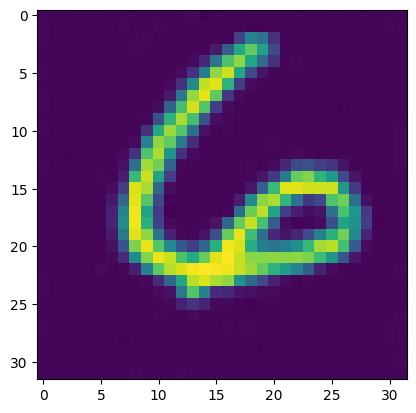

In [7]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(20,1,32,32).to(device)

img = rectified_flow_1.sample_ode(img_init, 10)

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

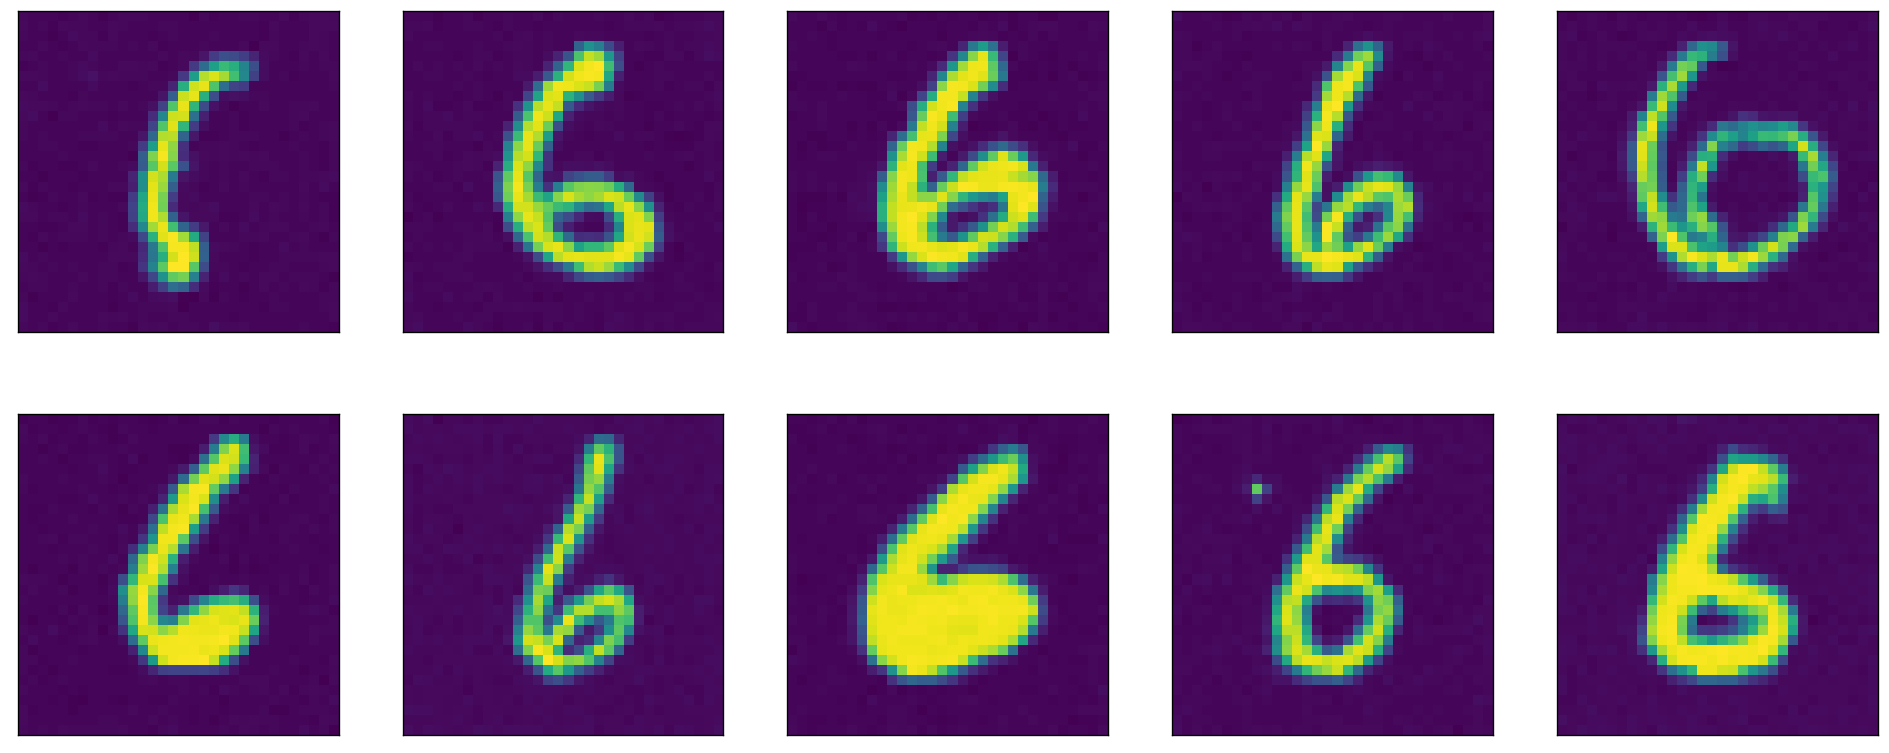

In [5]:
show_samples(rectified_flow_1, get_samples, rows=2, columns=5, channels=1, img_size=32, num_steps=66, device=device)

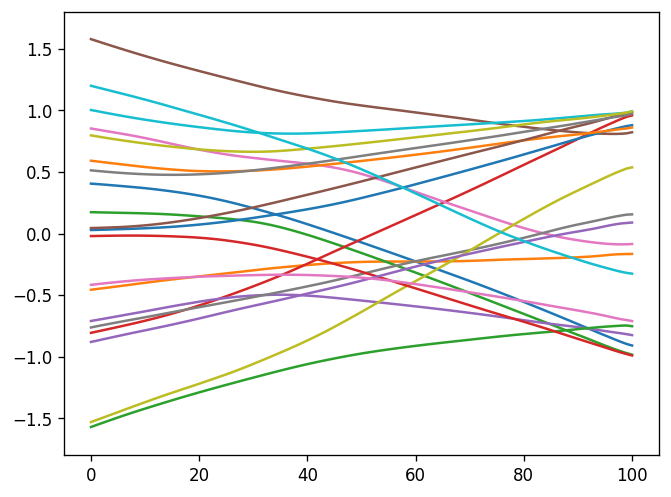

In [5]:
show_trajectories(rectified_flow_1, get_samples, img_size=32, num_steps=100, x=19, y=14, device=device)

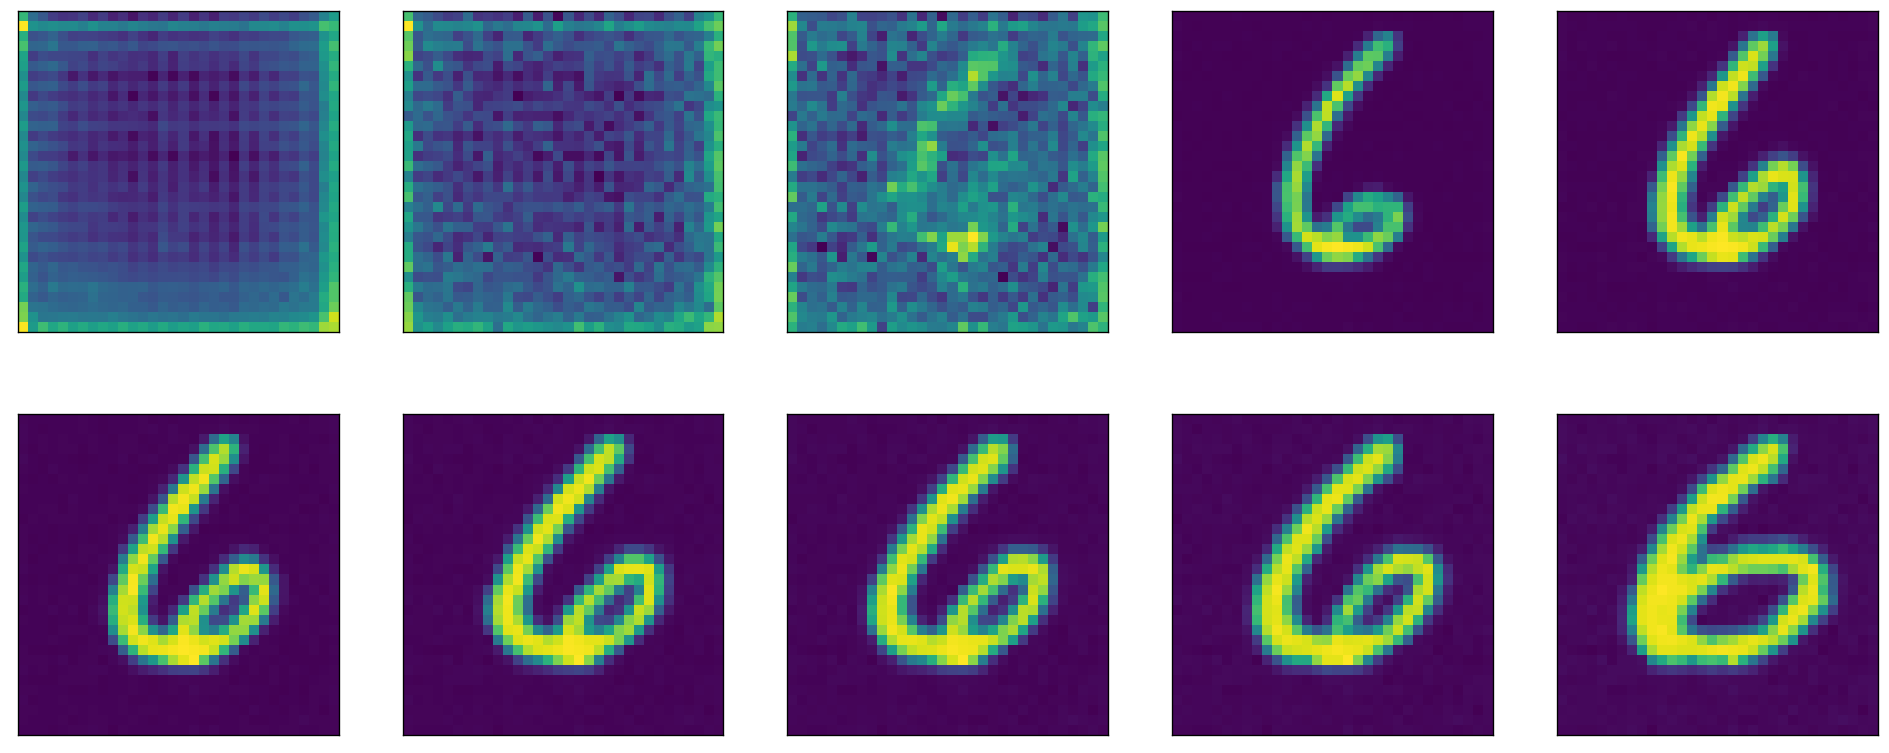

In [12]:
show_sample_temperature(rectified_flow_1, get_samples, 2, 5, 1, 32, 100, device)

## Reflow

In [5]:
# get sample pairs for reflow
k = 100
n = 1000
z0 = np.empty((k * n, 1, 32, 32))
z1 = np.empty((k * n, 1, 32, 32))
for i in range(k):
    samples_init = torch.randn(n,1,32,32).to(device)
    flow_1 = rectified_flow_1.sample_ode(samples_init, 100)[-1]
    z0[i*n:(i+1)*n] = samples_init.detach().clone().cpu()
    del samples_init
    z1[i*n:(i+1)*n] = flow_1.detach().clone().cpu()
    del flow_1
    torch.cuda.empty_cache()

In [92]:
np.save("MNIST/reflow_data/MNIST6_reflow_z0.npy", z0)

In [93]:
np.save("MNIST/reflow_data/MNIST6_reflow_z1.npy", z1)

In [95]:
z1 = np.load("MNIST/reflow_data/MNIST6_reflow_z1.npy")

In [7]:
v_model_reflow = U_Net_big(input_shape=input_shape, output_channels=1, device=device)
rectified_flow_reflow = RectifiedFlow_Unet(v_model_reflow, device)

In [8]:
optimizer_reflow = torch.optim.Adam(rectified_flow_reflow.v_model.parameters(), lr=1e-3)
scheduler_reflow = None # optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

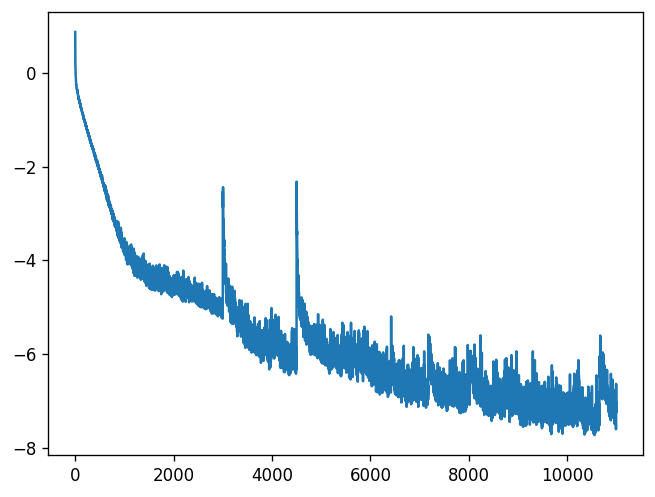

In [29]:
rectified_flow_reflow = train_reflow(rectified_flow_reflow, False, optimizer_reflow, scheduler_reflow, z0, z1, batch_size, device, epochs=2000, noise_factor=0)
plt.plot(np.log(rectified_flow_reflow.loss_curve))
plt.show()

In [30]:
torch.save(rectified_flow_reflow, "./models/MNIST/MNIST_6_Unet_good_reflow.pth")

In [9]:
rectified_flow_reflow = torch.load("./models/MNIST/MNIST_6_Unet_good_reflow.pth")

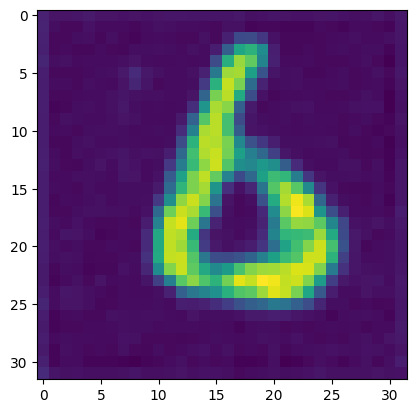

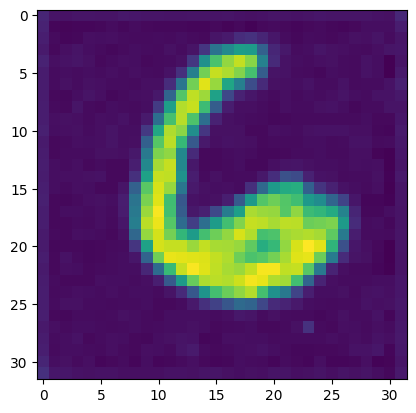

In [10]:
rectified_flow_reflow.v_model.eval()
img_init = torch.randn(20,1,32,32).to(device)

img = rectified_flow_reflow.sample_ode(img_init, 100)

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][1, 0].detach().cpu().numpy())
plt.show()

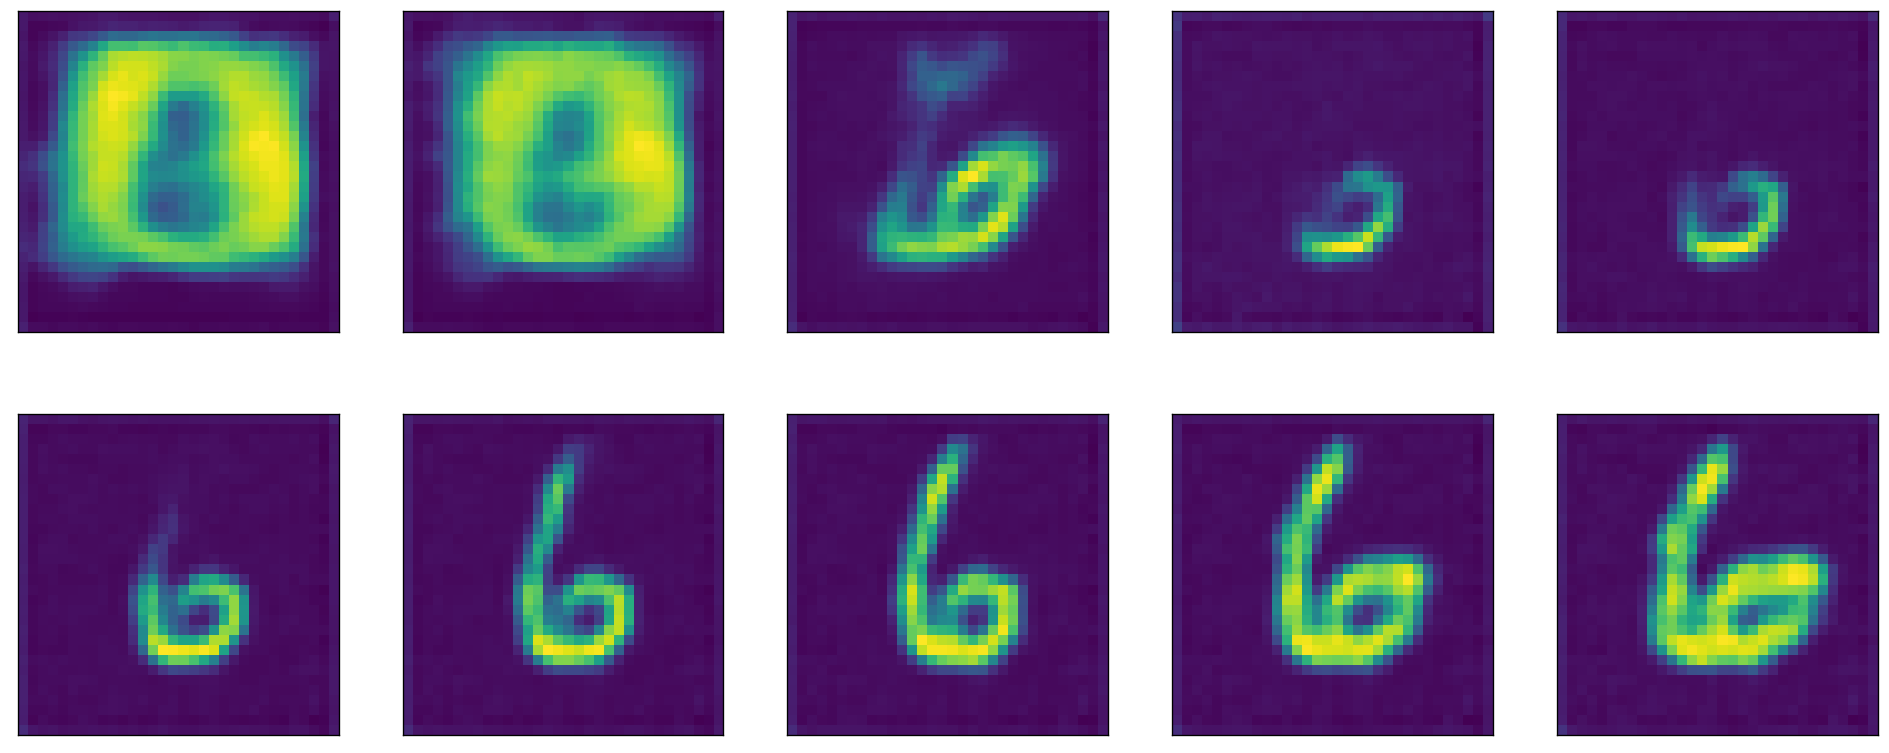

In [15]:
show_sample_temperature(rectified_flow_reflow, get_samples, 2, 5, 1, 32, 100, device)

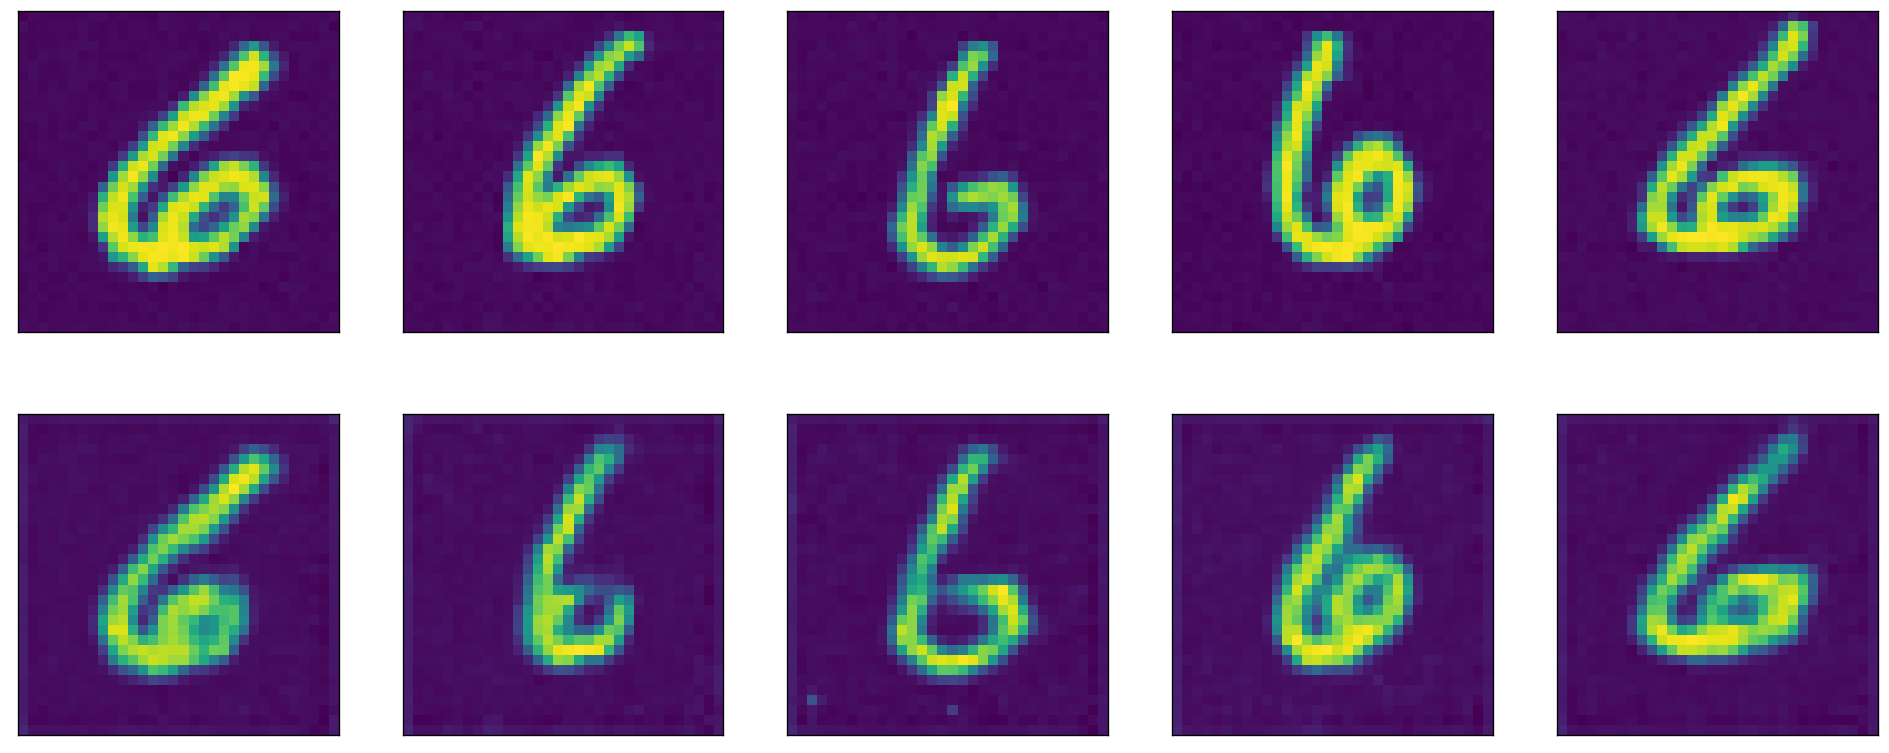

In [89]:
show_sample_flows([rectified_flow_1, rectified_flow_reflow], get_samples, 5, 1, 32, 100, device)

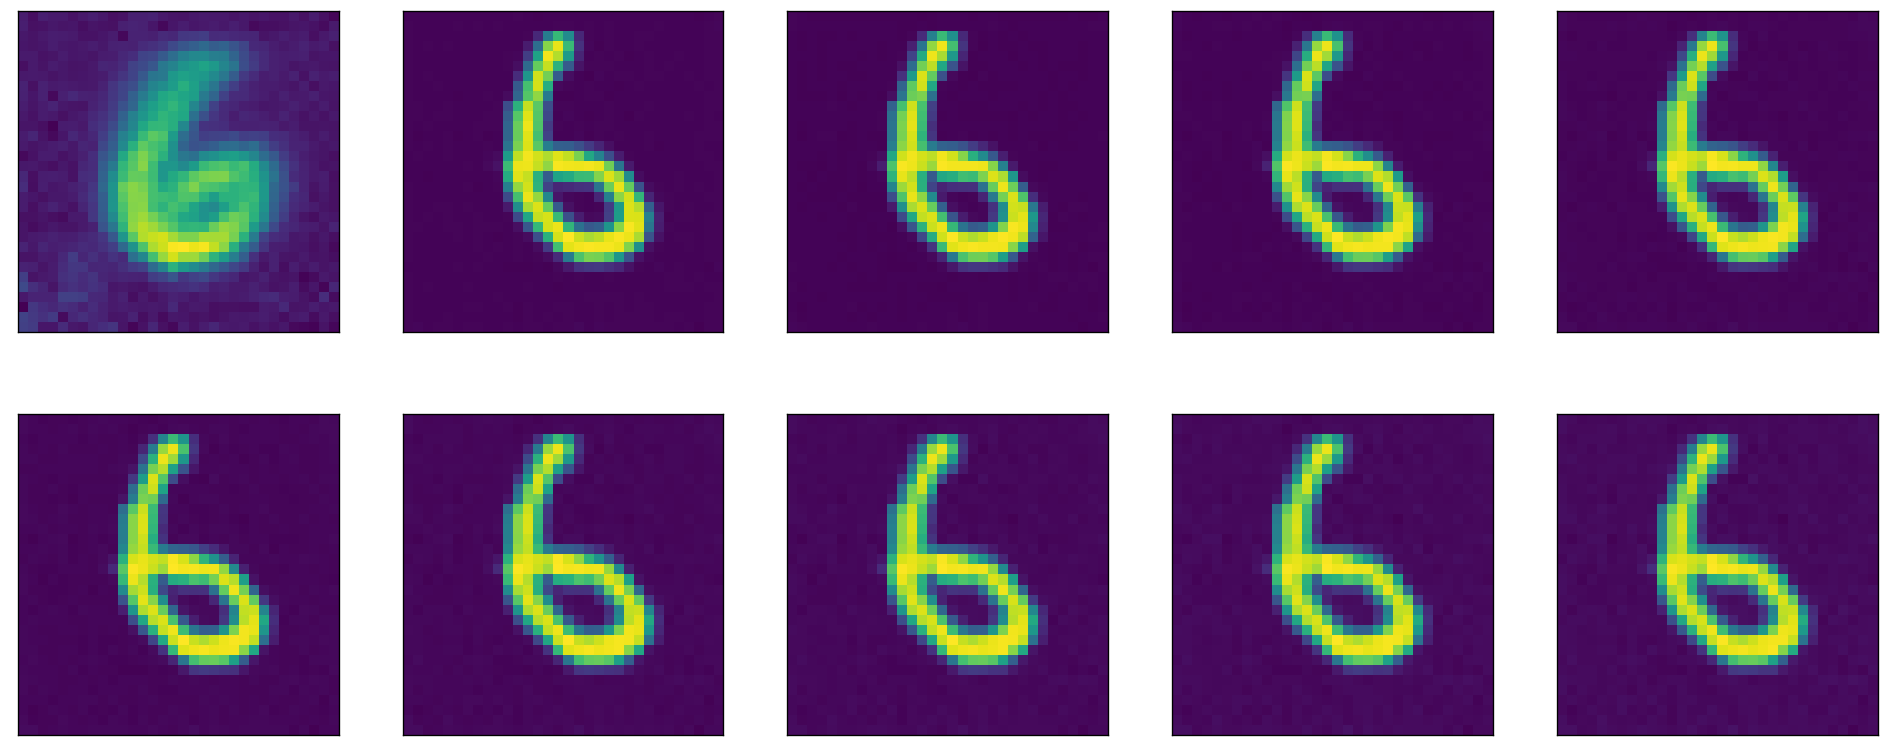

In [72]:
show_sample_steps(rectified_flow_1, get_samples, 2, 5, 1, 32, device)

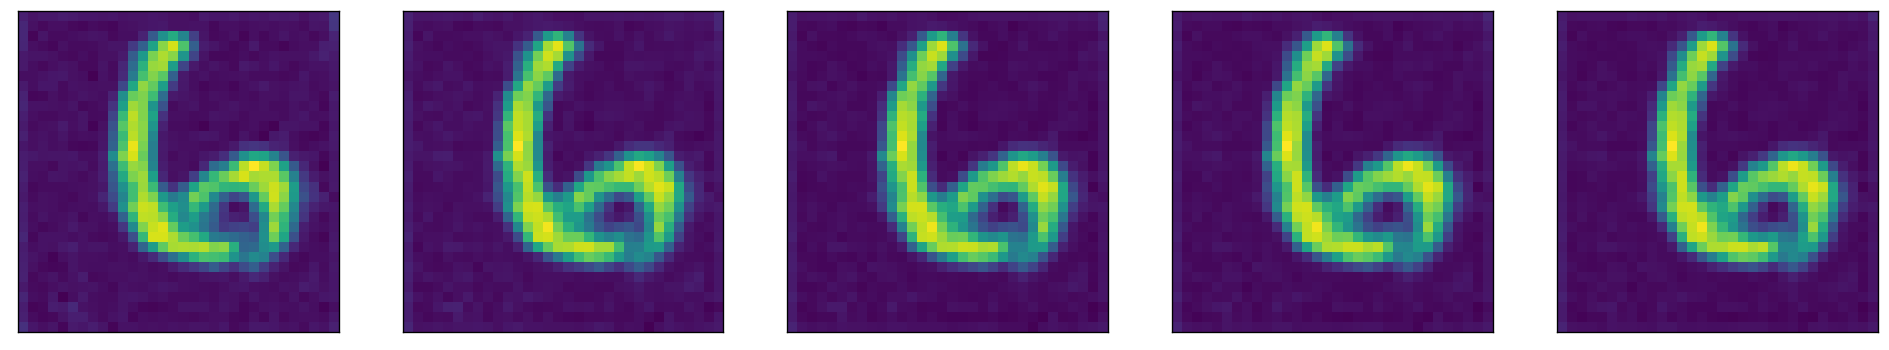

In [77]:
show_sample_steps(rectified_flow_reflow, get_samples, 1, 5, 1, 32, device)

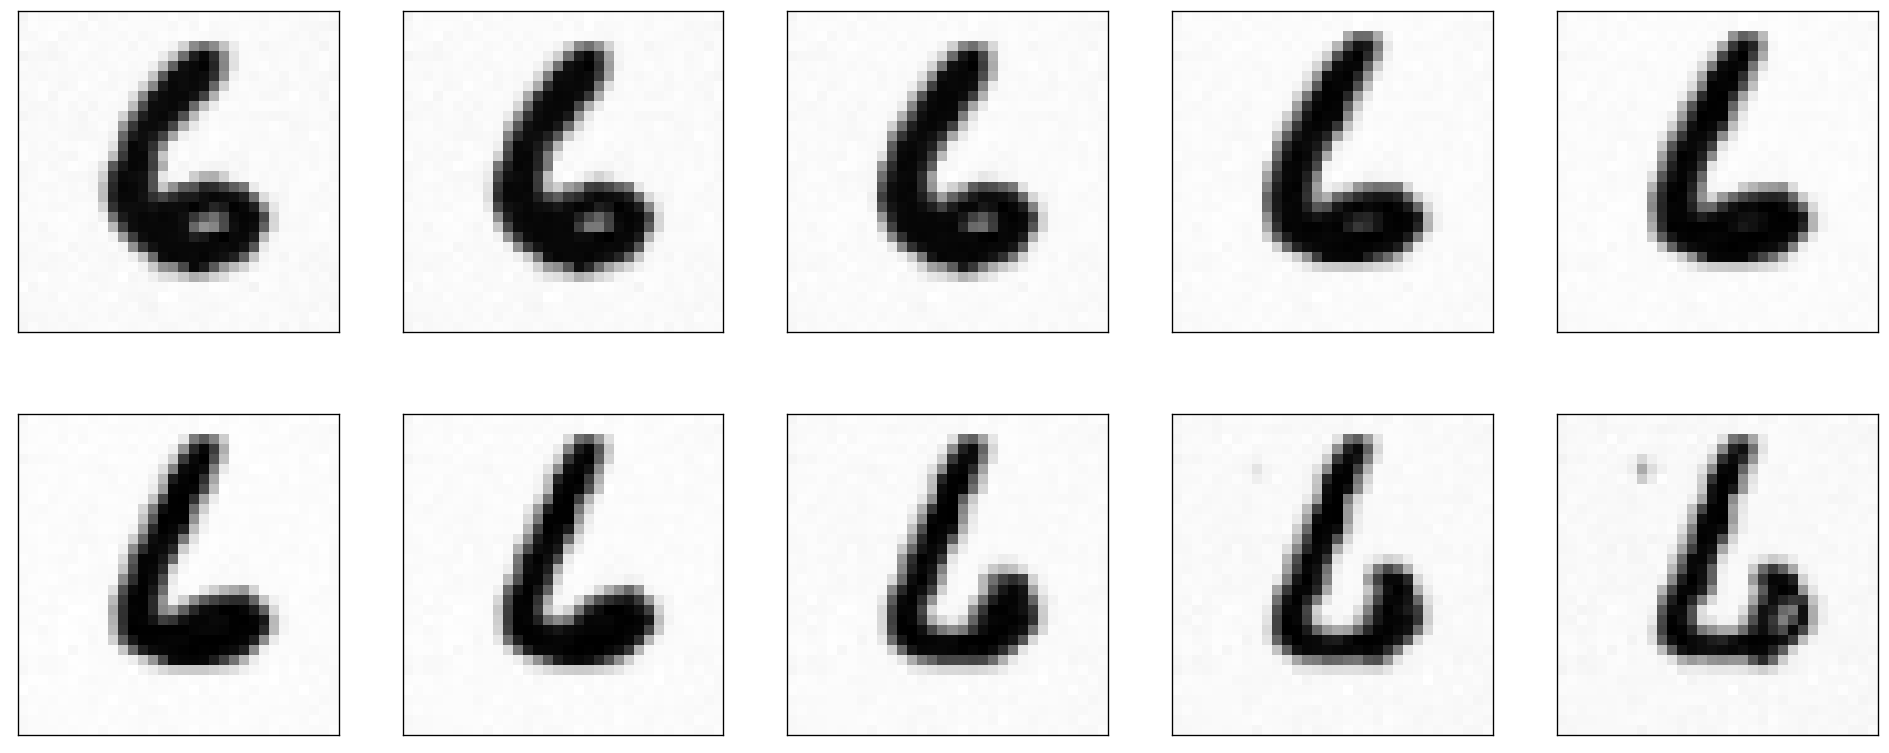

In [11]:
show_trajecrory_samples(rectified_flow_1, img_init[1:2], img_init[0:1], 2, 5, 100)

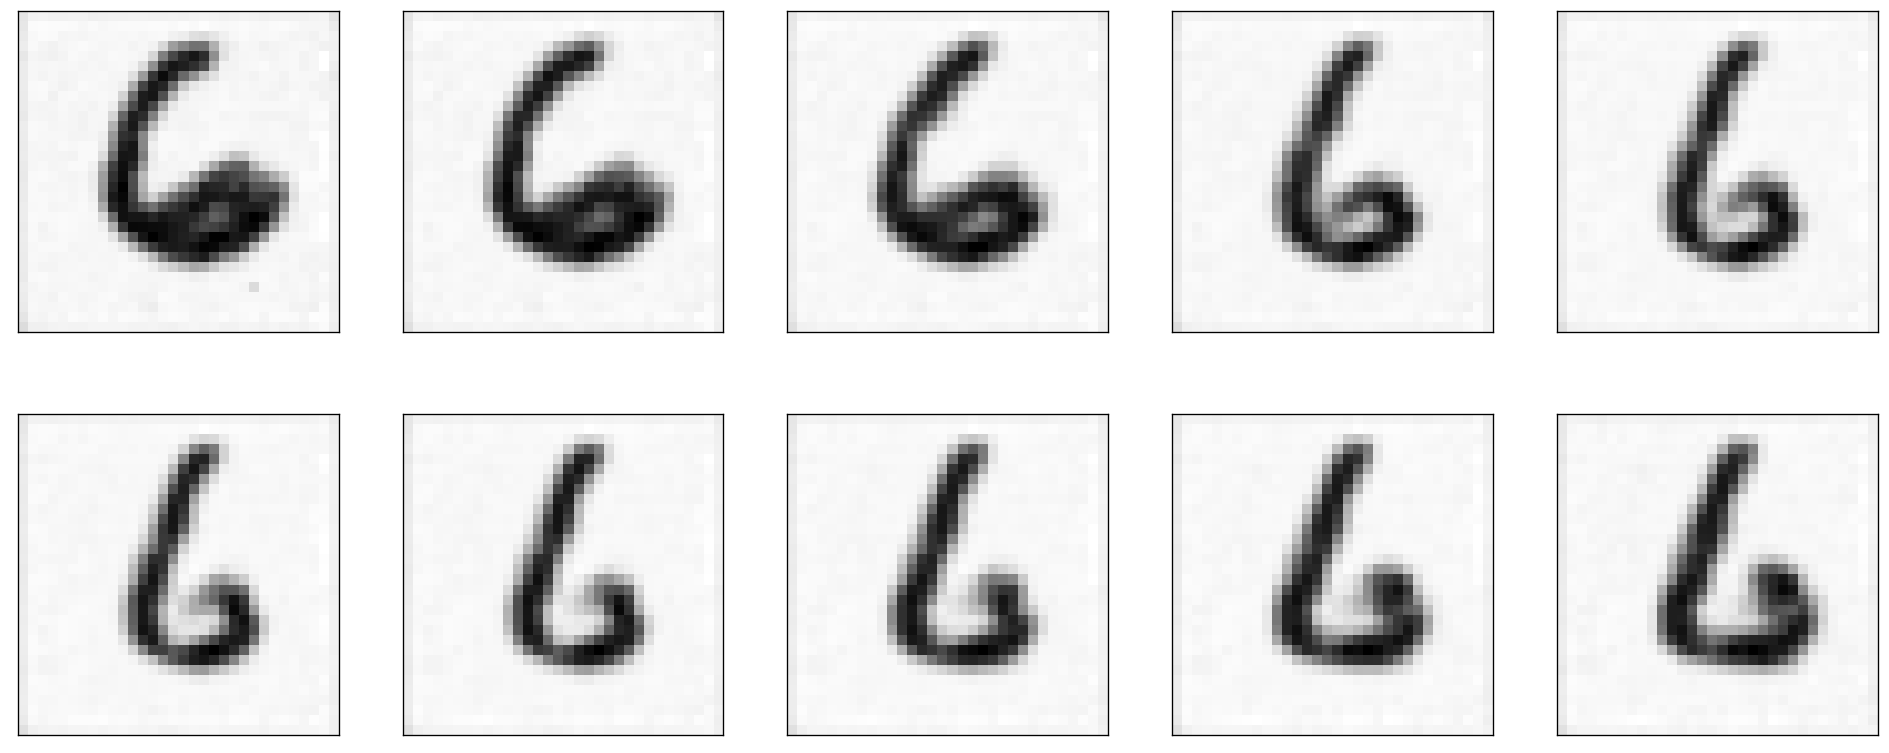

In [12]:
show_trajecrory_samples(rectified_flow_reflow, img_init[1:2], img_init[0:1], 2, 5, 100)

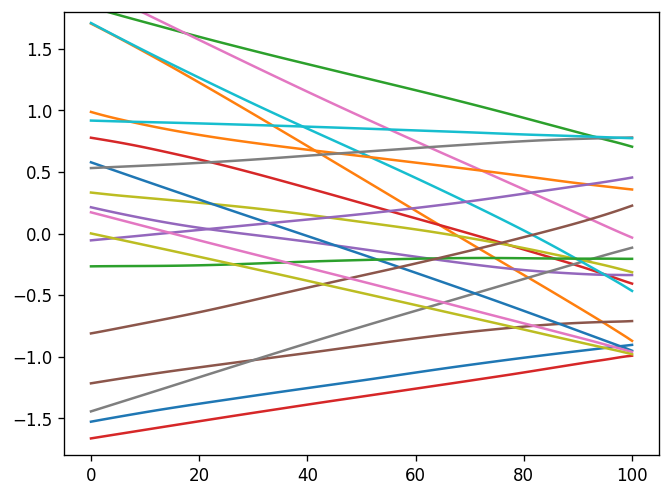

In [10]:
show_trajectories(rectified_flow_reflow, get_samples, img_size=32, num_steps=100, x=19, y=14, device=device)

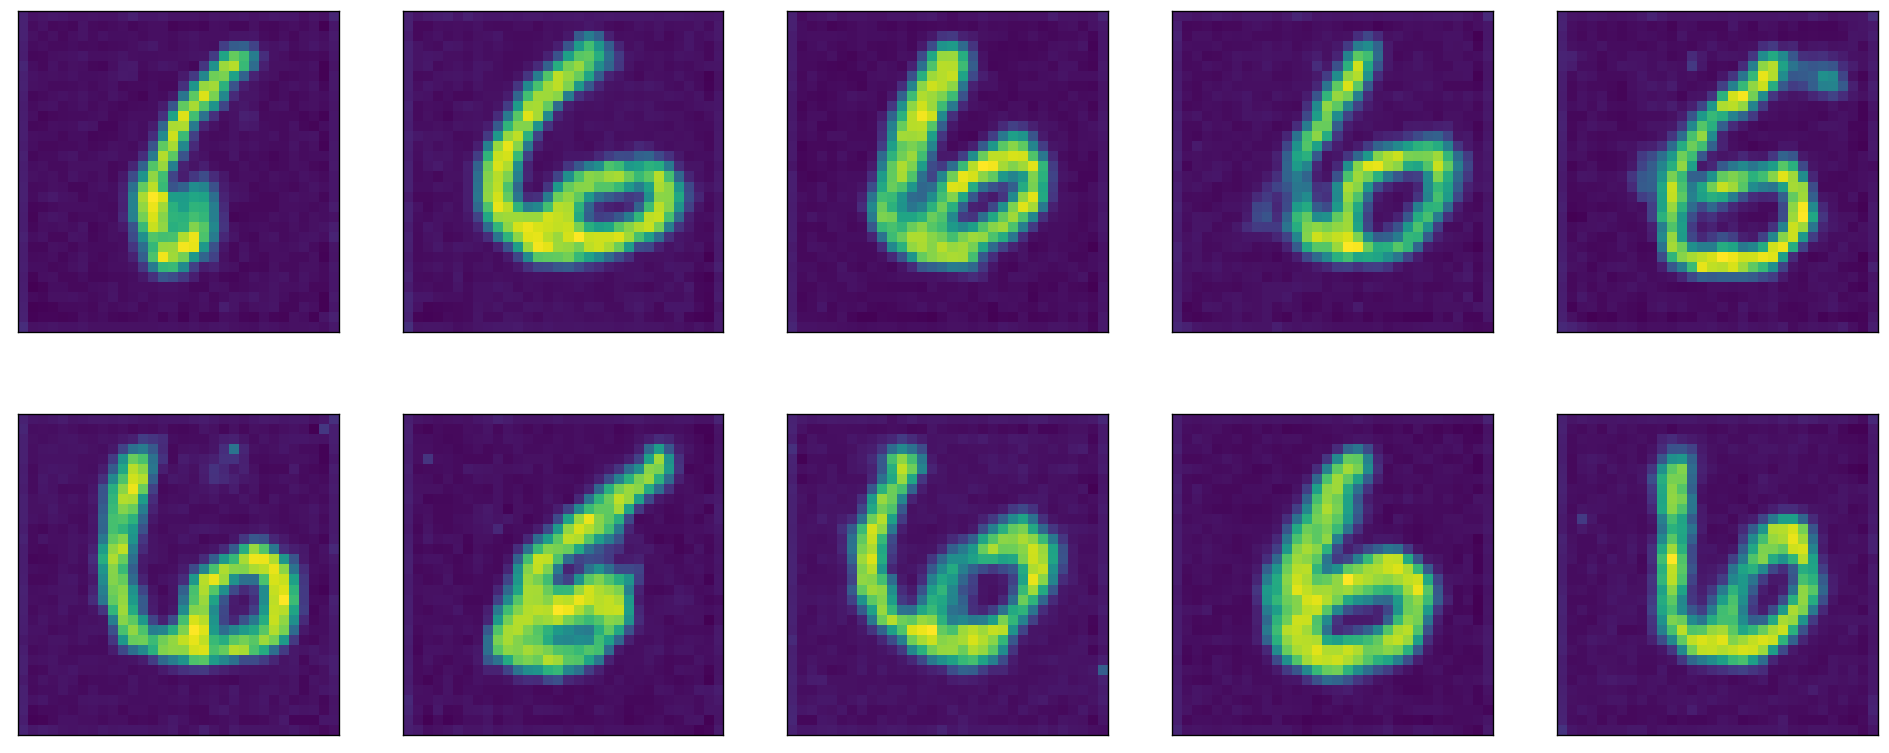

In [65]:
show_samples(rectified_flow_reflow, get_samples, rows=2, columns=5, channels=1, img_size=32, num_steps=4, device=device)

In [6]:
samples = [torch.randn(1,1,32,32).to(device) for i in range(10)]

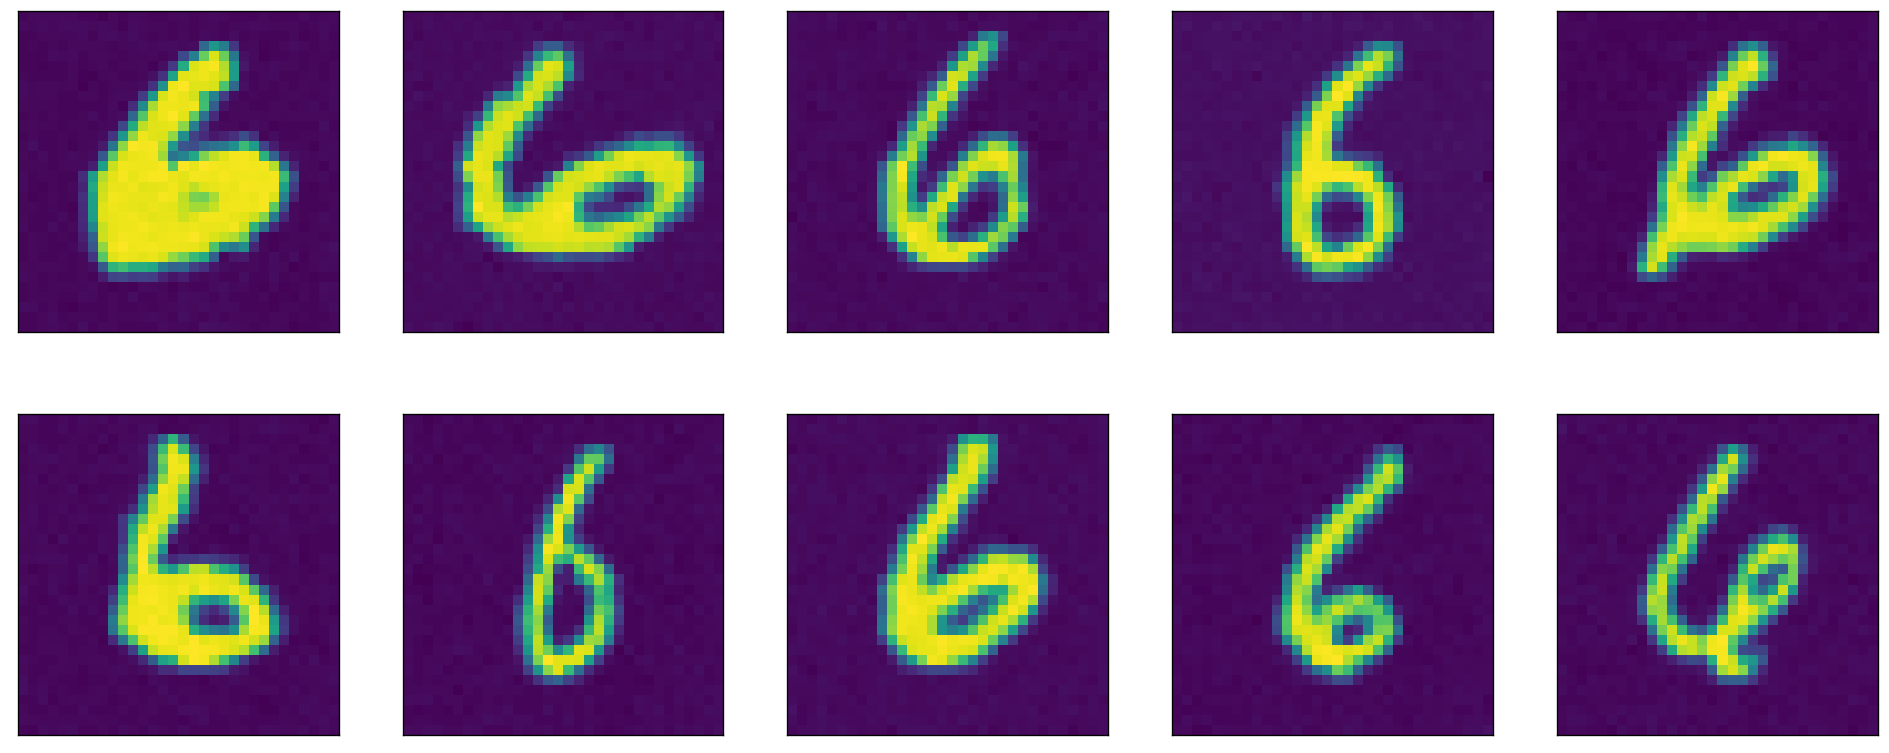

In [7]:
show_samples_array(rectified_flow_1, samples, 2, 5, 100, device)

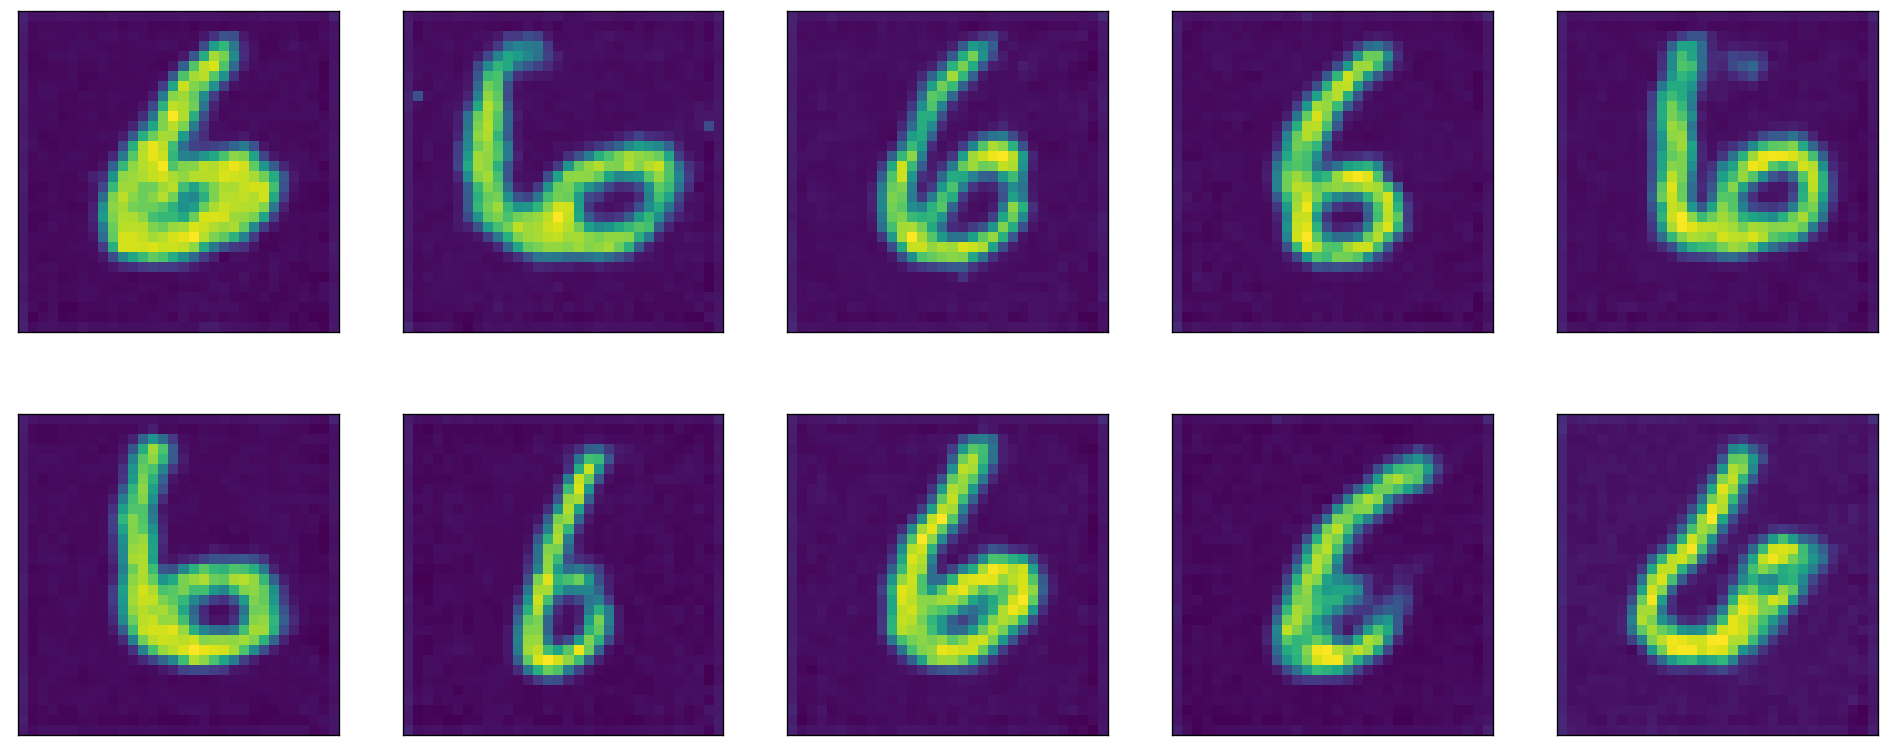

In [8]:
show_samples_array(rectified_flow_reflow, samples, 2, 5, 100, device)

In [24]:
def show_trajectories2(rectified_flow, rectified_flow_2, get_samples, num_samples, img_size, num_steps, x, y, device):
    rectified_flow.v_model.eval()
    plt.rcParams['figure.dpi'] = 120
    img_init = get_samples((num_samples, 1, img_size, img_size), device=device)
    img = rectified_flow.sample_ode(img_init, num_steps)
    s = torch.zeros(num_samples, len(img), 1, 32, 32)
    for i in range(len(img)):
        s[:, i] = img[i]
    for i in range(num_samples):
        plt.plot(s[i, :, 0, x, y].cpu().numpy())
    plt.ylim(-1.8, 1.8)
    plt.show()

    img = rectified_flow_2.sample_ode(img_init, num_steps)
    s = torch.zeros(num_samples, len(img), 1, 32, 32)
    for i in range(len(img)):
        s[:, i] = img[i]
    for i in range(num_samples):
        plt.plot(s[i, :, 0, x, y].cpu().numpy())
    plt.ylim(-1.8, 1.8)
    plt.show()

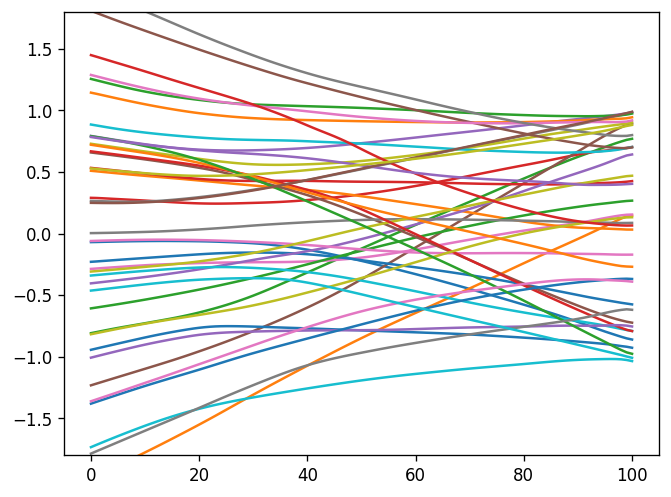

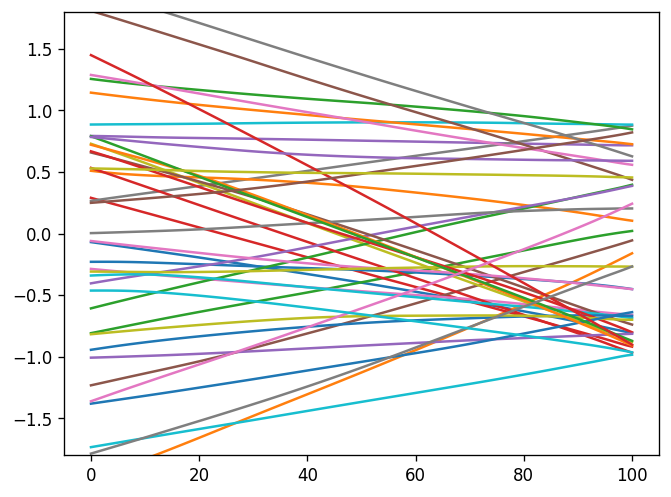

In [26]:
show_trajectories2(rectified_flow_1, rectified_flow_reflow, get_samples, 40, 32, 100, 19, 14, device)